# Computing the GP-DRT

In this example we are going to use a simple model to illustrate how active learning can be successfully applied in the field of EIS (see for more details: B. Py, A. Maradesa, and F. Ciucci. "Gaussian Processes for the Analysis of Electrochemical Impedance Spectroscopy Data: Prediction, Filtering, and Active Learning.", preprint (2022)). The model consists of a ZARC element connected in series with an inductance, and we study the active learning Cohn leveraging the determinant.

In [1]:
# import the libraries needed
import importlib
import GP_hilbert as gpf
importlib.reload(gpf)

import numpy as np
import matplotlib.pyplot as plt
from math import pi, log, sqrt, log10
from scipy.optimize import minimize, minimize_scalar
import seaborn as sns

In [2]:
# plot standards
plt.rc('font', family='serif', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

## 1) Define the synthetic impedance experiment $Z_{\rm exp}(\omega)$

### 1.1) Define frequency range

In [3]:
N_freqs = 41
freq_vec = np.logspace(-2., 6., num=N_freqs, endpoint=True)
omega_vec = 2.*pi*freq_vec

In [4]:
np.sum(1/freq_vec)/60

4.516189744524694

### 1.2) Define the circuit parameters

In [5]:
R_ct = 50 # Ohm
R_inf = 10. # Ohm
phi = 0.8 # dimensionless
tau_0 = 1E-1 # s
L_0 = 5E-6 # F

### 1.3) Generate exact impedance $Z_{\rm exact}(\omega)$ 

In [6]:
T = tau_0**phi/R_ct
Z_exact = R_inf +  1j*(2*pi*freq_vec)*L_0 + 1./(1./R_ct+T*(1j*2.*pi*freq_vec)**phi)

### 1.4) Generate stochastic experiment with $Z_{\rm exp}(\omega) = Z_{\rm exact}(\omega)+ \sigma_n (\varepsilon_{\rm re} + i\varepsilon_{\rm im})$ with $\varepsilon_{\rm re}$ and $\varepsilon_{\rm im}$ are independent and identically distributed normals centered with 0 mean and standard deviation equal to 1

In [7]:
N_freqs_10ppd = 81
rng = np.random.seed(2421975) # seed the random number generator
sigma_n_exp = 0.3
noise_10_ppd = (sigma_n_exp)*(np.random.normal(0, 1, N_freqs_10ppd)+1j*np.random.normal(0, 1, N_freqs_10ppd))
Z_exp = Z_exact + noise_10_ppd[::2]

### 1.5) Plot

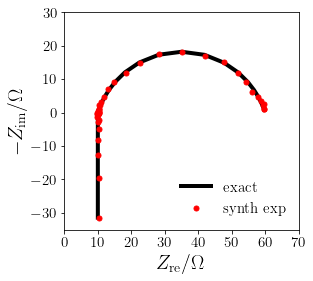

In [8]:
fig, ax = plt.subplots()
plt.plot(Z_exact.real, -Z_exact.imag, linewidth=4, color='black', label='exact')
plt.plot(Z_exp.real, -Z_exp.imag, 'o', markersize=5, color='red', label='synth exp')

plt.legend(frameon=False, fontsize=15, loc='lower right')
plt.axis('scaled')

plt.xlim(0, 70)
plt.ylim(-35, 30)
plt.xticks(range(0, 80, 10))
plt.yticks(range(-30, 40, 10))
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()

## 2) Set the kernel options 

In [9]:
ker_opts = {
    'sigma_DRT': 1.,
    'sigma_SB': 1.,
    'ell': 1.,
    'tau_max': 1e1,
    'DRT': True,
    'SB': False,
    'SB_ker_type': 'IQ',
}

# these values are nominal

In [10]:
ker_opts_0 = ker_opts.copy()

## 3) Fit imaginary part of the data

### 3.1) Initialize the hyperparameters

In [11]:
sigma_n = 0.8
sigma_DRT = 30
sigma_SB = 6E-1
ell = 15
sigma_L = 5E-6

### 3.2) Maximize the NMLL

In [12]:
theta_0 = np.array([sigma_n, sigma_DRT, sigma_SB, ell, sigma_L])
seq_theta = np.copy(theta_0)

def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('%.4E, %.4E, %.4E, %.4E, %.6E; evidence = %.8E'%(theta[0], theta[1], theta[2], theta[3], theta[4], gpf.NMLL_fct(theta, Z_exp.imag, omega_vec, ker_opts, 'im')))
    
res = minimize(gpf.NMLL_fct, theta_0, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Powell', \
               callback=print_results, options={'disp': True, 'xtol': 1E-6, 'ftol': 1E-6})

res = minimize(gpf.NMLL_fct, res.x, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Nelder-Mead', \
                callback=print_results, options={'disp': True, 'xatol': 1E-6, 'fatol': 1E-6})

theta_im = res.x
sigma_n, sigma_DRT, sigma_SB, ell, sigma_L = theta_im

-2.9661E-01, 2.8523E+01, 3.2176E+00, 1.7618E+01, 5.006576E-06; evidence = 4.36460054E+00
-2.9656E-01, 2.8523E+01, 5.8352E+00, 2.0235E+01, 5.006576E-06; evidence = 4.36459989E+00
Optimization terminated successfully.
         Current function value: 4.364600
         Iterations: 2
         Function evaluations: 211
-2.9656E-01, 2.8523E+01, 5.8352E+00, 2.0235E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8352E+00, 2.0235E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8352E+00, 2.0235E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8352E+00, 2.0235E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8352E+00, 2.0235E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8352E+00, 2.0235E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8352E+00, 2.0235E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8352E+00, 2.0235E+01, 5.006576E-06

-2.9656E-01, 2.8523E+01, 5.8412E+00, 2.0256E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8412E+00, 2.0256E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8412E+00, 2.0256E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8412E+00, 2.0256E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8412E+00, 2.0256E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8412E+00, 2.0256E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8412E+00, 2.0256E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8412E+00, 2.0256E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8412E+00, 2.0256E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8412E+00, 2.0256E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+01, 5.8412E+00, 2.0256E+01, 5.006576E-06; evidence = 4.36459989E+00
-2.9656E-01, 2.8523E+

In [13]:
# update the values of the kernel
# as the gpf functions simply copy ker_opts
ker_opts['sigma_SB'] = sigma_SB
ker_opts['ell'] = ell
ker_opts['sigma_DRT'] = sigma_DRT

In [14]:
importlib.reload(gpf)
theta_new, ker_opts_new = gpf.compute_opt_theta(theta_im, ker_opts, freq_vec, Z_exp.imag, type_data = 'im')

-2.9656E-01, 2.8523E+01, 8.4588E+00, 2.2874E+01, 5.006576E-06; evidence = 4.36459989E+00
Optimization terminated successfully.
         Current function value: 4.364600
         Iterations: 1
         Function evaluations: 129


### 3.3) Check if the results are reasonable

#### 3.3.1) Check $L_0$

In [15]:
K_im = gpf.mat_K(omega_vec, omega_vec, ker_opts, 'im')
Sigma = (sigma_n**2)*np.eye(N_freqs)
K_full = K_im + Sigma + (sigma_L**2)*np.outer(omega_vec, omega_vec)
K_full_reg = K_im + Sigma

# Cholesky-decompose K_full
# begin FC - added 
if not gpf.is_PD(K_full_reg):
    K_full_reg = gpf.nearest_PD(K_full_reg)

# end FC - added

# inverse of K_im
L = np.linalg.cholesky(K_full_reg)
inv_L = np.linalg.inv(L)
inv_K_full_reg = np.dot(inv_L.T, inv_L)

num_L_0 = omega_vec@(inv_K_full_reg@Z_exp.imag)
den_L_0 = (sigma_L**-2) + omega_vec@(inv_K_full_reg@omega_vec)
L_0_est = num_L_0/den_L_0

print('L_0_est = %.6E F vs. L_0 = %.6E F'%(L_0_est, L_0))

L_0_est = 5.006438E-06 F vs. L_0 = 5.000000E-06 F


#### 3.3.2) Check the fit of $\Im(Z_{\rm exp})$ against the GP

##### 3.3.2.1) Run the GP regression

In [16]:
# Cholesky-decompose K_full
# begin FC - added 
if not gpf.is_PD(K_full):
    K_full = gpf.nearest_PD(K_full)

# end FC - added 

# cholesky factorization
L = np.linalg.cholesky(K_full)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_full = np.dot(inv_L.T, inv_L)

N_star_freqs = N_freqs
freq_star_vec = np.copy(freq_vec) #np.logspace(-4., 4., num=N_star_freqs, endpoint=True)
omega_star_vec = 2.*pi*freq_star_vec

mu_star_vec = np.zeros_like(omega_star_vec)
sigma_star_vec = np.zeros_like(omega_star_vec)

for index, omega_star in enumerate(omega_star_vec):
    
    #print('iter = ', index+1, '/', N_star_freqs)
    omega_star_np = np.array([omega_star])
    k_star_star = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 'im').flatten() + (sigma_L**2)*omega_star_np**2
    k_star = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 'im').flatten() + (sigma_L**2)*omega_vec*omega_star_np
    
    mu_star_vec[index] = k_star@(inv_K_full@Z_exp.imag)
    sigma_star_vec[index] = np.sqrt(k_star_star - k_star@(inv_K_full@k_star))

##### 3.3.2.2) Plot the outcome of the GP regression

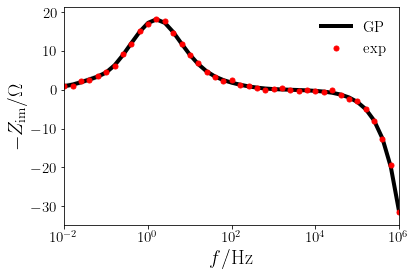

In [17]:
plt.fill_between(freq_star_vec, -mu_star_vec-3*sigma_star_vec, -mu_star_vec+3*sigma_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, -mu_star_vec-2*sigma_star_vec, -mu_star_vec+2*sigma_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, -mu_star_vec-sigma_star_vec, -mu_star_vec+sigma_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, -mu_star_vec, linewidth=4, color='black', label='GP')
plt.semilogx(freq_vec,  -Z_exp.imag, 'o', markersize=5, color='red', label='exp')
plt.xlim(1E-2, 1E6)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

## 4) Fit real part of the data

### 4.1) Initialize the hyperparameters

In [18]:
sigma_n = 0.8
sigma_DRT = 30
sigma_SB = 6E-7
ell = 3
sigma_R = 10

### 4.2) Maximize the NMLL

In [19]:
theta_0 = np.array([sigma_n, sigma_DRT, sigma_SB, ell, sigma_R])

seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('%.4E, %.4E, %.4E, %.4E, %.6E; evidence = %.8E'%(theta[0], theta[1], theta[2], theta[3], theta[4], gpf.NMLL_fct(theta, Z_exp.real, omega_vec, ker_opts, 're')))
    
res = minimize(gpf.NMLL_fct, theta_0, args=(Z_exp.real, omega_vec, ker_opts, 're'), method='Powell', \
               callback=print_results, options={'disp': True, 'xtol': 1E-6, 'ftol': 1E-6})

res = minimize(gpf.NMLL_fct, res.x, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Nelder-Mead', \
               callback=print_results, options={'disp': True, 'xatol': 1E-6, 'fatol': 1E-6})

theta_re = res.x
sigma_n, sigma_DRT, sigma_SB, ell, sigma_R = theta_re

-1.9806E-01, 2.7813E+01, 2.6176E+00, 5.6176E+00, 1.013680E+01; evidence = -5.01600536E+00
-1.9813E-01, 2.7813E+01, 5.2352E+00, 8.2352E+00, 1.013680E+01; evidence = -5.01600815E+00
Optimization terminated successfully.
         Current function value: -5.016008
         Iterations: 2
         Function evaluations: 221
-1.9813E-01, 2.9204E+01, 5.2352E+00, 8.2352E+00, 1.013680E+01; evidence = -4.98660189E+00
-2.0011E-01, 2.8786E+01, 5.2875E+00, 8.3175E+00, 9.883379E+00; evidence = -4.99790021E+00
-2.0011E-01, 2.8786E+01, 5.2875E+00, 8.3175E+00, 9.883379E+00; evidence = -4.99790021E+00
-2.0011E-01, 2.8786E+01, 5.2875E+00, 8.3175E+00, 9.883379E+00; evidence = -4.99790021E+00
-2.0011E-01, 2.8786E+01, 5.2875E+00, 8.3175E+00, 9.883379E+00; evidence = -4.99790021E+00
-2.0057E-01, 2.8852E+01, 5.2475E+00, 8.2627E+00, 9.956871E+00; evidence = -4.99484512E+00
-2.0057E-01, 2.8852E+01, 5.2475E+00, 8.2627E+00, 9.956871E+00; evidence = -4.99484512E+00
-2.0057E-01, 2.8852E+01, 5.2475E+00, 8.2627E+00, 9.

-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-0

-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-01, 2.8618E+01, 5.2715E+00, 8.2951E+00, 9.872880E+00; evidence = -4.99580060E+00
-2.0184E-0

In [20]:
# update the values of the kernel
# as the gpf functions simply copy ker_opts
ker_opts['sigma_SB'] = sigma_SB
ker_opts['ell'] = ell
ker_opts['sigma_DRT'] = sigma_DRT

### 4.3) Check if the results are reasonable

#### 4.3.1) Check $R_\infty$

In [21]:
K_re = gpf.mat_K(omega_vec, omega_vec, ker_opts, 're')
Sigma = (sigma_n**2)*np.eye(N_freqs)
K_full = K_re + Sigma + (sigma_R**2)*np.ones_like(Sigma)
K_full_reg = K_re + Sigma

# Cholesky-decompose K_full
# begin FC - added 
if not gpf.is_PD(K_full_reg):
    K_full_reg = gpf.nearest_PD(K_full_reg)

# end FC - added

# inverse of K_re
L = np.linalg.cholesky(K_full_reg)
inv_L = np.linalg.inv(L)
inv_K_full_reg = np.dot(inv_L.T, inv_L)

num_R_inf = np.ones(N_freqs)@(inv_K_full_reg@Z_exp.real)
den_R_inf = (sigma_R**-2) + np.ones(N_freqs)@(inv_K_full_reg@np.ones(N_freqs))
R_inf_est = num_R_inf/den_R_inf

print('R_inf_est = %.6E Ohm vs. R_inf = %.6E Ohm'%(R_inf_est, R_inf))

R_inf_est = 1.013681E+01 Ohm vs. R_inf = 1.000000E+01 Ohm


#### 4.3.2) Check the fit of $\Re(Z_{\rm exp})$ against the GP

##### 4.3.2.1) Run the GP regression

In [22]:
# Cholesky-decompose K_full
# begin FC - added 
if not gpf.is_PD(K_full):
    K_full = gpf.nearest_PD(K_full)

# end FC - added 

# cholesky factorization
L = np.linalg.cholesky(K_full)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_full = np.dot(inv_L.T, inv_L)

N_star_freqs = N_freqs
freq_star_vec = np.copy(freq_vec) #np.logspace(-4., 4., num=N_star_freqs, endpoint=True)
omega_star_vec = 2.*pi*freq_star_vec

mu_star_vec = np.zeros_like(omega_star_vec)
sigma_star_vec = np.zeros_like(omega_star_vec)

for index, omega_star in enumerate(omega_star_vec):
    #print('iter = ', index+1, '/', N_star_freqs)
    omega_star_np = np.array([omega_star])
    
    k_star_star = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 're').flatten() + (sigma_R**2)
    k_star = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 're').flatten() + (sigma_R**2)*np.ones(N_freqs)

    mu_star_vec[index] = k_star@(inv_K_full@Z_exp.real)
    sigma_star_vec[index] = np.sqrt(k_star_star - k_star@(inv_K_full@k_star))

##### 4.3.2.2) Plot the outcome of the GP regression

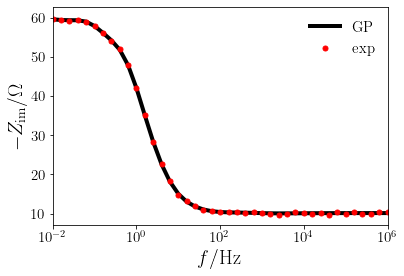

In [23]:
plt.fill_between(freq_star_vec, mu_star_vec-3*sigma_star_vec, mu_star_vec+3*sigma_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, mu_star_vec-2*sigma_star_vec, mu_star_vec+2*sigma_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, mu_star_vec-sigma_star_vec, mu_star_vec+sigma_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, mu_star_vec, linewidth=4, color='black', label='GP')
plt.semilogx(freq_vec,  Z_exp.real, 'o', markersize=5, color='red', label='exp')
plt.xlim(1E-2, 1E6)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

## 5) Bundle things together

In [24]:
Z_exp_all = np.zeros(2*N_freqs)
Z_exp_all[:N_freqs] = Z_exp.real
Z_exp_all[N_freqs:] = Z_exp.imag

### 5.1) Initialize the hyperparameters

In [25]:
sigma_n, sigma_DRT, sigma_SB, ell = 0.5*(abs(theta_re[:4])+abs(theta_im[:4]))
sigma_R = abs(theta_re[-1])
sigma_L = abs(theta_im[-1])

In [26]:
theta_0 = [sigma_n, sigma_DRT, sigma_SB, ell, sigma_R, sigma_L]
seq_theta = np.copy(theta_0)

def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('%.4E, %.4E, %.4E, %.4E, %.4E, %.6E; evidence = %.8E'%(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], gpf.NMLL_fct(theta, Z_exp_all, omega_vec, ker_opts, 'all')))
    
res = minimize(gpf.NMLL_fct, theta_0, args=(Z_exp_all, omega_vec, ker_opts, 'all'), method='Powell', \
               callback=print_results, options={'disp': True, 'xtol': 1E-6, 'ftol': 1E-6})
#res = minimize(gpf.NMLL_fct, res.x, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Nelder-Mead', \
               #callback=print_results, options={'disp': True, 'xatol': 1E-6, 'fatol': 1E-6})

theta = res.x
sigma_n, sigma_DRT, sigma_SB, ell, sigma_R, sigma_L = theta

2.8668E-01, 2.6554E+01, 8.1740E+00, 1.6893E+01, 1.0121E+01, 5.005731E-06; evidence = -1.70688775E+01
2.8638E-01, 2.6553E+01, 1.0771E+01, 1.9490E+01, 1.0121E+01, 5.005727E-06; evidence = -1.70689500E+01
Optimization terminated successfully.
         Current function value: -17.068950
         Iterations: 2
         Function evaluations: 256


In [27]:
# update the values of the kernel
# as the gpf functions simply copy ker_opts
ker_opts['sigma_SB'] = sigma_SB
ker_opts['ell'] = ell
ker_opts['sigma_DRT'] = sigma_DRT

### 5.2) Check if the results are reasonable

compute blocks

In [28]:
K_re = gpf.mat_K(omega_vec, omega_vec, ker_opts, 're')
K_im = gpf.mat_K(omega_vec, omega_vec, ker_opts, 'im')
K_re_im = gpf.mat_K(omega_vec, omega_vec, ker_opts, 're-im')
K_im_re = gpf.mat_K(omega_vec, omega_vec, ker_opts, 'im-re')

assemble full matrix

In [29]:
Sigma = sigma_n**2*np.eye(N_freqs)
K_full = np.zeros((2*N_freqs, 2*N_freqs))
K_full[:N_freqs, :N_freqs] = K_re + Sigma + (sigma_R**2)*np.ones(N_freqs)
K_full[:N_freqs, N_freqs:] = K_re_im
K_full[N_freqs:, :N_freqs] = K_im_re
K_full[N_freqs:, N_freqs:] = K_im + Sigma + (sigma_L**2)*np.outer(omega_vec, omega_vec)

ensure the full matrix is positive definite

In [30]:
if not gpf.is_PD(K_full):
    K_full = gpf.nearest_PD(K_full)

# cholesky factorization
L = np.linalg.cholesky(K_full)

compute cholesky

In [31]:
# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_full = np.dot(inv_L.T, inv_L)

#### 5.2.1) Run GP regression

In [32]:
N_star_freqs = N_freqs
freq_star_vec = np.copy(freq_vec)
omega_star_vec = 2.*pi*freq_star_vec

mu_re_star_vec = np.zeros_like(omega_star_vec)
sigma_re_star_vec = np.zeros_like(omega_star_vec)

mu_im_star_vec = np.zeros_like(omega_star_vec)
sigma_im_star_vec = np.zeros_like(omega_star_vec)


for index, omega_star in enumerate(omega_star_vec):
    
    #print('iter = ', index+1, '/', N_star_freqs)
    omega_star_np = np.array([omega_star])
    
    # k_star_star
    k_star_star_re = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 're').flatten() + (sigma_R**2)
    k_star_star_im = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 'im').flatten() + (sigma_L**2)*omega_star_np**2
    
    # k_star    
    k_star_re_re = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 're').flatten() + (sigma_R**2)*np.ones(N_freqs)
    k_star_re_im = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 're-im').flatten()
    k_star_im_re = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 'im-re').flatten()
    k_star_im_im = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 'im').flatten() + (sigma_L**2)*omega_vec*omega_star_np

    # k_star_re
    k_star_re = np.zeros(2*N_freqs)
    k_star_re[:N_freqs] = k_star_re_re
    k_star_re[N_freqs:] = k_star_re_im
    
    # k_star_im
    k_star_im = np.zeros(2*N_freqs)
    k_star_im[:N_freqs] = k_star_im_re
    k_star_im[N_freqs:] = k_star_im_im
    
    mu_re_star_vec[index] = k_star_re@(inv_K_full@Z_exp_all)
    sigma_re_star_vec[index] = np.sqrt(k_star_star_re - k_star_re@(inv_K_full@k_star_re))
    
    mu_im_star_vec[index] = k_star_im@(inv_K_full@Z_exp_all)
    sigma_im_star_vec[index] = np.sqrt(k_star_star_im - k_star_im@(inv_K_full@k_star_im))

##### 5.2.1.1) Plot the regressed imaginary part

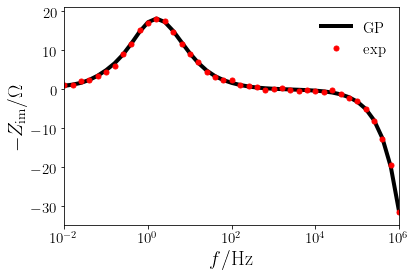

In [33]:
plt.fill_between(freq_star_vec, -mu_im_star_vec-3*sigma_im_star_vec, -mu_im_star_vec+3*sigma_im_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, -mu_im_star_vec-2*sigma_im_star_vec, -mu_im_star_vec+2*sigma_im_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, -mu_im_star_vec-sigma_im_star_vec, -mu_im_star_vec+sigma_im_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, -mu_im_star_vec, linewidth=4, color='black', label='GP')
plt.semilogx(freq_vec,  -Z_exp.imag, 'o', markersize=5, color='red', label='exp')
plt.xlim(1E-2, 1E6)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

##### 5.2.1.2) Plot the regressed real part

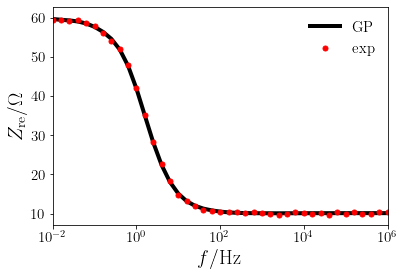

In [34]:
plt.fill_between(freq_star_vec, mu_re_star_vec-3*sigma_re_star_vec, mu_re_star_vec+3*sigma_re_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, mu_re_star_vec-2*sigma_re_star_vec, mu_re_star_vec+2*sigma_re_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, mu_re_star_vec-sigma_re_star_vec, mu_re_star_vec+sigma_re_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, mu_re_star_vec, linewidth=4, color='black', label='GP')
plt.semilogx(freq_vec,  Z_exp.real, 'o', markersize=5, color='red', label='exp')
plt.xlim(1E-2, 1E6)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$Z_{\rm re}/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

##### 5.2.1.3) Imaginary difference plot

In [35]:
diff_im = -mu_im_star_vec+Z_exact.imag
sigma_diff_im = sigma_im_star_vec

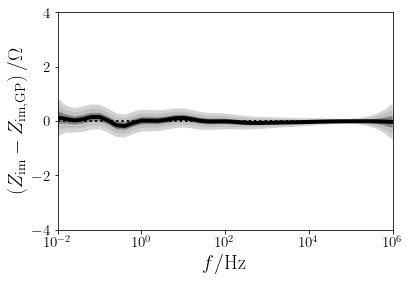

In [36]:
plt.fill_between(freq_star_vec, diff_im-3*sigma_diff_im, diff_im+3*sigma_diff_im,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, diff_im-2*sigma_diff_im, diff_im+2*sigma_diff_im,  facecolor='silver')
plt.fill_between(freq_star_vec, diff_im-sigma_diff_im, diff_im+sigma_diff_im,  facecolor='grey')
plt.semilogx(freq_star_vec, diff_im, linewidth=4, color='black', label='GP')
plt.semilogx(freq_star_vec, np.zeros_like(freq_star_vec), linewidth=2, color='black', ls = ':')
plt.xlim(1E-2, 1E6)
plt.ylim(-4, 4)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$\left(Z_{\rm im}-Z_{\rm im, GP}\right)/\Omega$', fontsize=20)
plt.show()

##### 5.2.1.4) Real difference plot

In [37]:
diff_re = -mu_re_star_vec+Z_exact.real
sigma_diff_re = sigma_re_star_vec

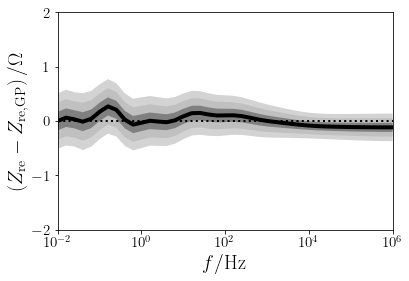

In [39]:
plt.fill_between(freq_star_vec, diff_re-3*sigma_diff_re, diff_re+3*sigma_diff_re,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, diff_re-2*sigma_diff_re, diff_re+2*sigma_diff_re,  facecolor='silver')
plt.fill_between(freq_star_vec, diff_re-sigma_diff_re, diff_re+sigma_diff_re,  facecolor='grey')
plt.semilogx(freq_star_vec, diff_re, linewidth=4, color='black', label='GP')
plt.semilogx(freq_star_vec, np.zeros_like(freq_star_vec), linewidth=2, color='black', ls = ':')
plt.xlim(1E-2, 1E6)
plt.ylim(-2, 2)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$\left(Z_{\rm re}-Z_{\rm re, GP}\right)/\Omega$', fontsize=20)
plt.show()

## Adaptive learning

In [39]:
importlib.reload(gpf)

ppd = 40
N_virt_freqs = 8*ppd+1
freq_virt_vec = np.logspace(-2., 6., num=N_virt_freqs, endpoint=True)

theta_N = np.copy(theta)
ker_opts_N = ker_opts.copy()
freq_vec_N = np.copy(freq_vec)
Z_exp_N = np.copy(Z_exp)
Z_exp_all_N = np.copy(Z_exp_all)
inv_K_full_N = np.copy(inv_K_full)

T_N = np.sum(1/freq_vec_N) 
T_10_ppd = np.sum(1/np.logspace(-2., 6., num=81, endpoint=True))

mu_re_virt_vec_0, mu_im_virt_vec_0, sigma_re_virt_vec_0, sigma_im_virt_vec_0 = \
    gpf.compute_mu_sigma(theta, ker_opts, inv_K_full, freq_virt_vec, freq_vec, Z_exp_all)

In [40]:
freq_vec_10ppd = np.logspace(-2., 6., num=N_freqs_10ppd, endpoint=True)
inv_K_full_10ppd = gpf.compute_K_inv(theta, ker_opts, freq_vec_10ppd)

Z_exact_10ppd = R_inf + 1j*(2*pi*freq_vec_10ppd)*L_0 + 1./(1./R_ct+T*(1j*2.*pi*freq_vec_10ppd)**phi)
Z_exp_10ppd = Z_exact_10ppd + noise_10_ppd

Z_exp_all_10ppd = np.zeros(2*N_freqs_10ppd)
Z_exp_all_10ppd[:N_freqs_10ppd] = Z_exp_10ppd.real
Z_exp_all_10ppd[N_freqs_10ppd:] = Z_exp_10ppd.imag

mu_re_virt_vec_10ppd, mu_im_virt_vec_10ppd, sigma_re_virt_vec_10ppd, sigma_im_virt_vec_10ppd = \
    gpf.compute_mu_sigma(theta, ker_opts, inv_K_full_10ppd, freq_virt_vec, freq_vec_10ppd, Z_exp_all_10ppd)

In [41]:
iter_max = 100
freq_new_vec = np.zeros(iter_max)
Z_exp_new_vec = np.zeros(iter_max, dtype=np.complex_)
theta_new_vec = np.zeros((iter_max, 6))

mu_re_virt_vec_new_vec = np.zeros((iter_max, N_virt_freqs))
mu_im_virt_vec_new_vec = np.zeros((iter_max, N_virt_freqs))
sigma_re_virt_vec_new_vec = np.zeros((iter_max, N_virt_freqs))
sigma_im_virt_vec_new_vec = np.zeros((iter_max, N_virt_freqs))

In [42]:
import GP_hilbert as gpf
importlib.reload(gpf)

<module 'GP_hilbert' from 'C:\\Users\\pybap\\OED\\PR-OED article\\1ZARC\\0.3\\v18_det_sigma_0.3\\GP_hilbert.py'>

### show ALC results

In [43]:
# integration over a coarse log-spaced mesh
log10_freq_vec_int = np.linspace(-2., 6., num=81, endpoint=True)
ALC = np.zeros_like(log10_freq_vec_int)

In [44]:
gpf.compute_ALC(-1, theta, ker_opts, freq_vec, log10_freq_vec_int)

0.0019000770923342399

In [45]:
# run ALC
for iter, log10_freq in enumerate(log10_freq_vec_int):
    ALC[iter] = gpf.compute_ALC(log10_freq, theta, ker_opts, freq_vec, log10_freq_vec_int)

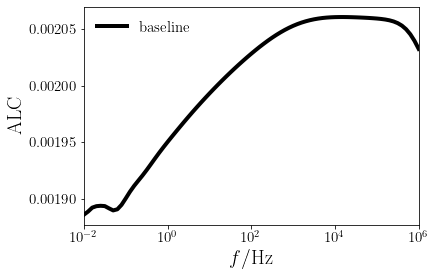

In [46]:
# plot ALC
plt.semilogx(10**log10_freq_vec_int, ALC, linewidth=4, color='black', linestyle = '-', label = 'baseline')
plt.xlim(1E-2, 1E6)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'ALC', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

### run ALC optimization

iter =  1 / 100 ; freq_new = 5.2501E-02
2.8628E-01, 2.6493E+01, 1.3389E+01, 2.2108E+01, 1.0121E+01, 5.005727E-06; evidence = -1.83379860E+01
2.8628E-01, 2.6493E+01, 1.6006E+01, 2.4725E+01, 1.0121E+01, 5.005727E-06; evidence = -1.83379861E+01
Optimization terminated successfully.
         Current function value: -18.337986
         Iterations: 2
         Function evaluations: 297


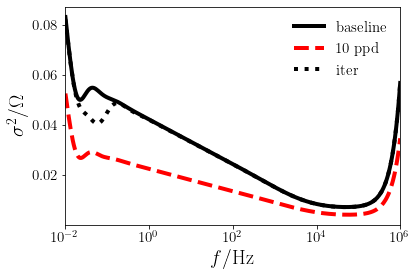

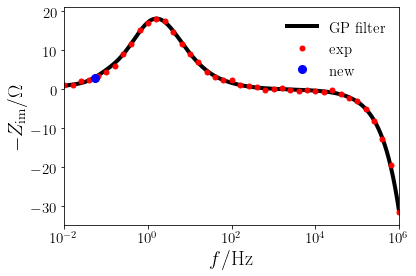

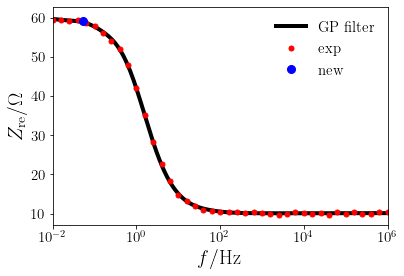

iter =  2 / 100 ; freq_new = 2.0877E-01


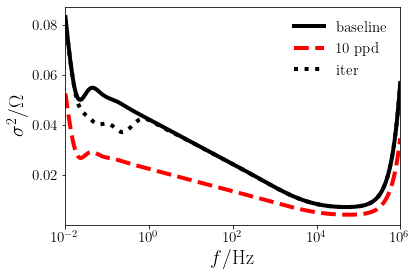

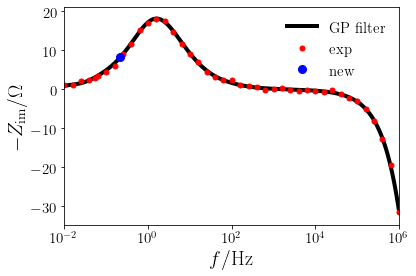

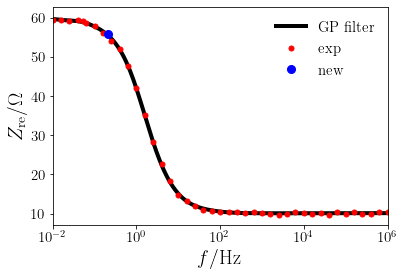

iter =  3 / 100 ; freq_new = 8.9433E-01


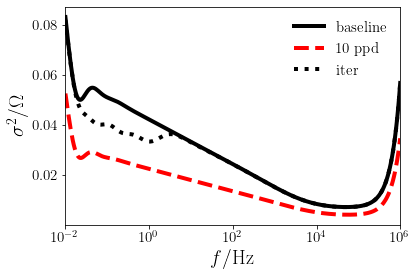

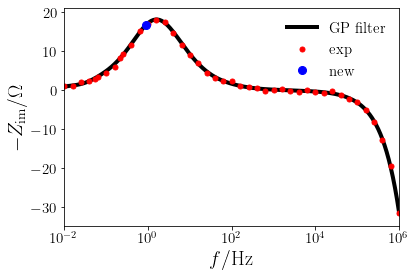

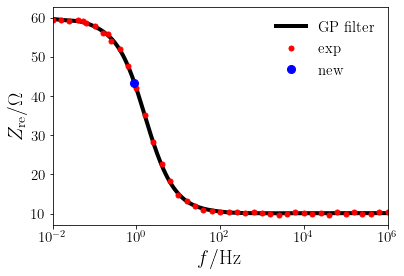

iter =  4 / 100 ; freq_new = 3.8888E+00


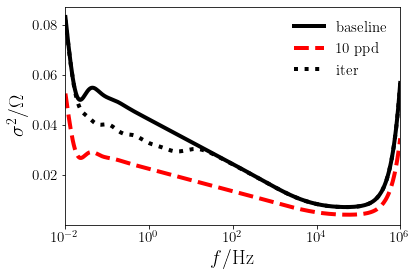

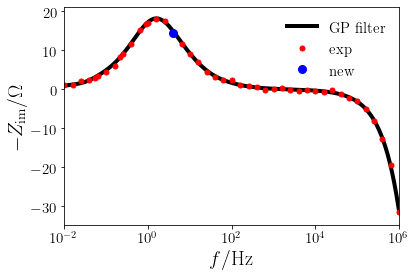

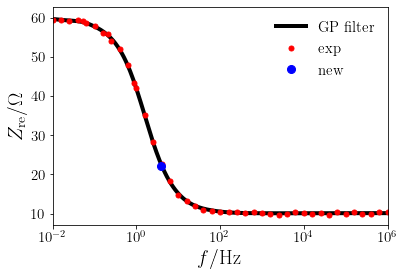

iter =  5 / 100 ; freq_new = 1.0661E-02


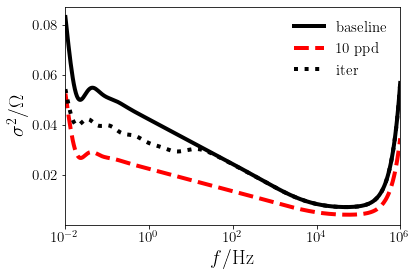

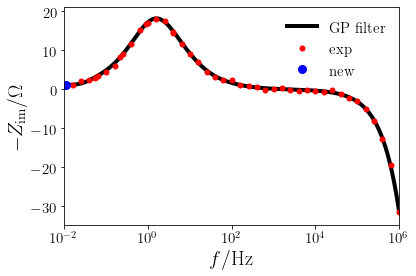

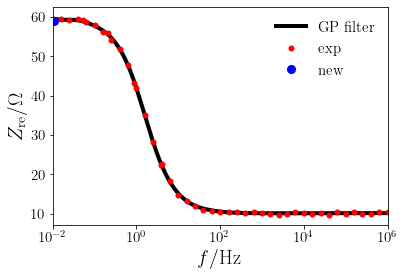

iter =  6 / 100 ; freq_new = 1.4846E+01


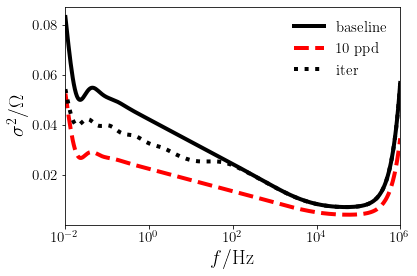

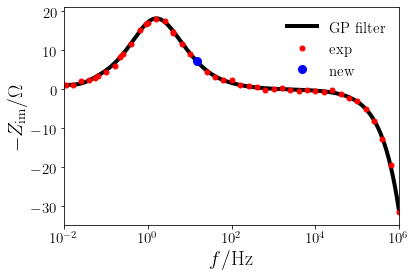

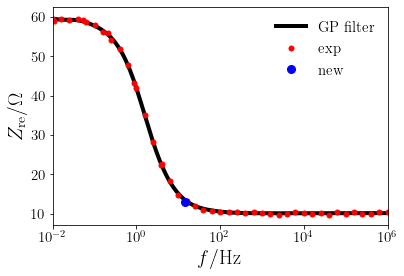

iter =  7 / 100 ; freq_new = 2.8662E-02


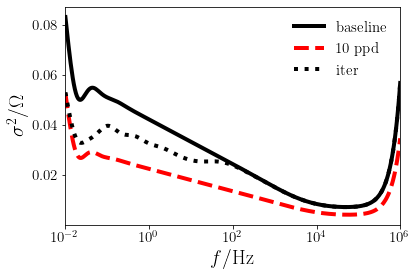

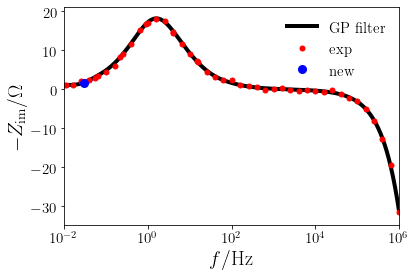

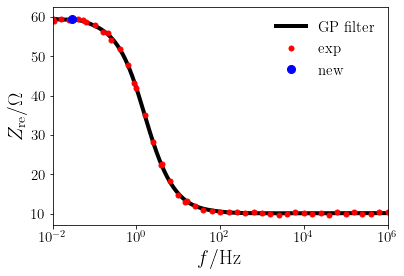

iter =  8 / 100 ; freq_new = 1.0944E-01


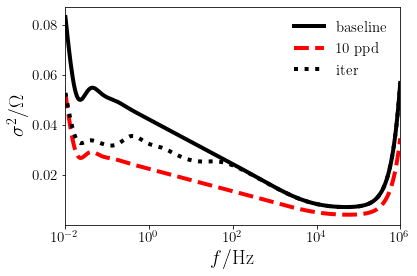

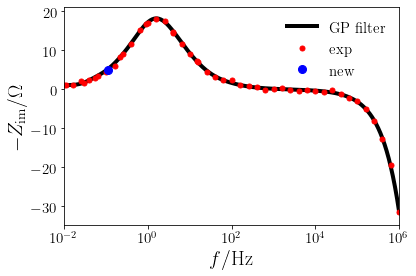

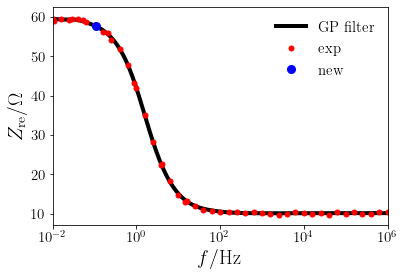

iter =  9 / 100 ; freq_new = 4.4581E-01


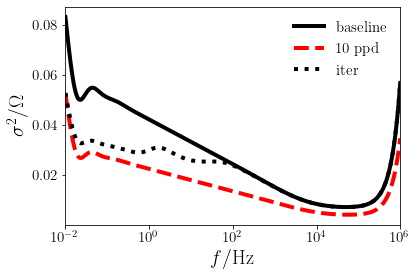

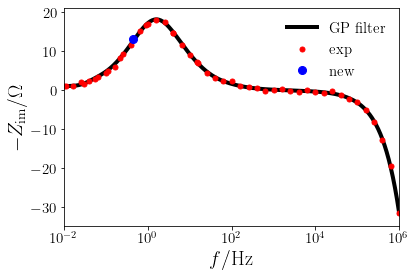

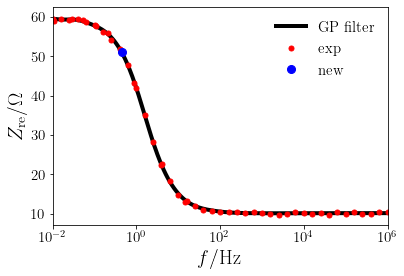

iter =  10 / 100 ; freq_new = 1.8329E+00


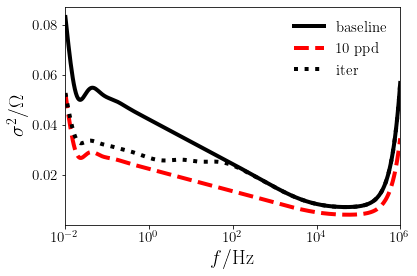

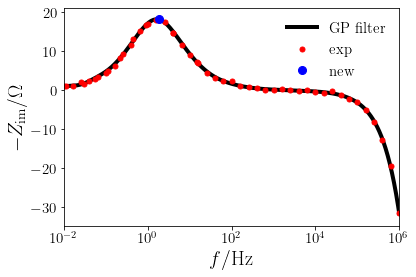

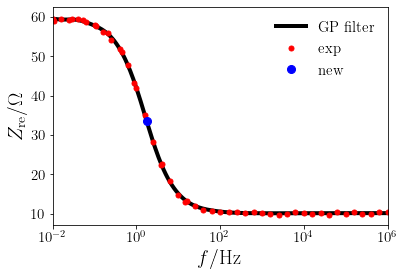

iter =  11 / 100 ; freq_new = 3.8365E+01


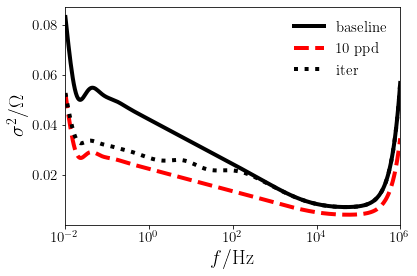

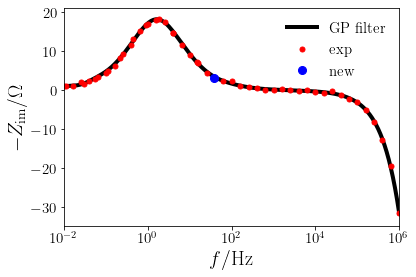

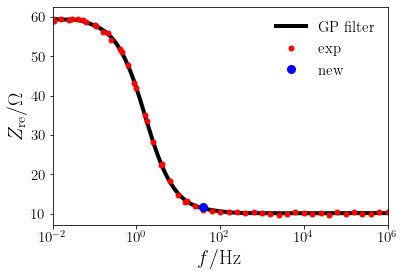

iter =  12 / 100 ; freq_new = 5.2037E+00


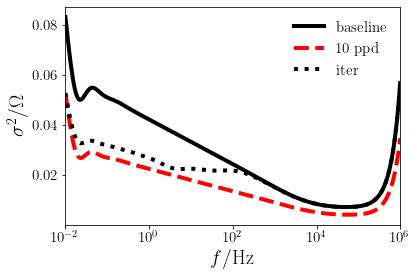

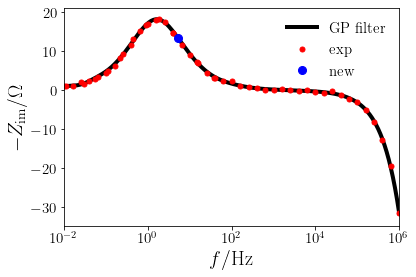

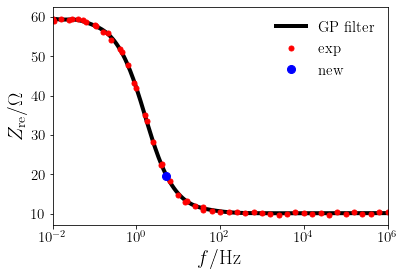

iter =  13 / 100 ; freq_new = 8.1170E+01


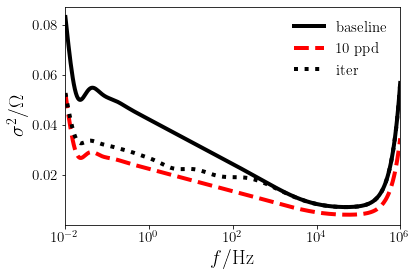

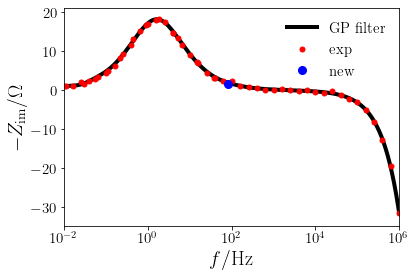

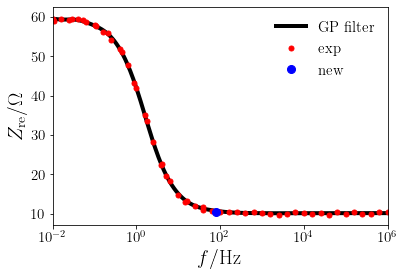

iter =  14 / 100 ; freq_new = 9.5572E+00


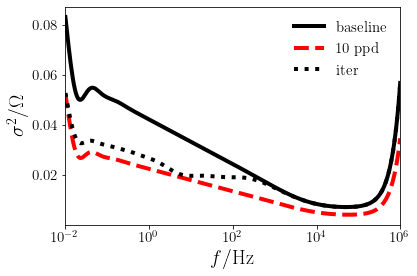

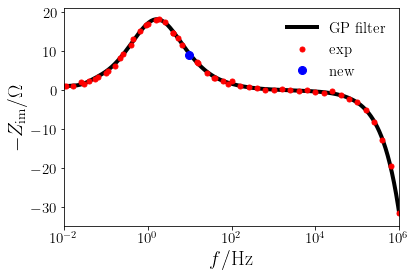

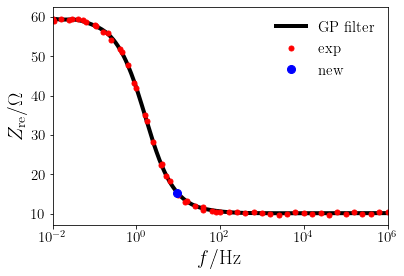

iter =  15 / 100 ; freq_new = 1.1756E+02


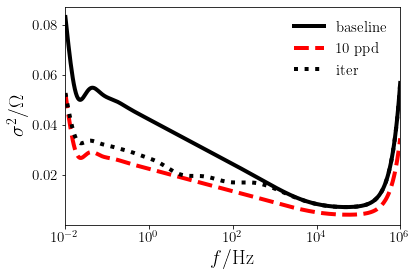

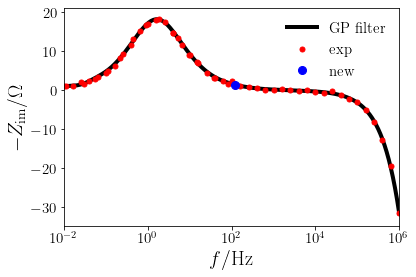

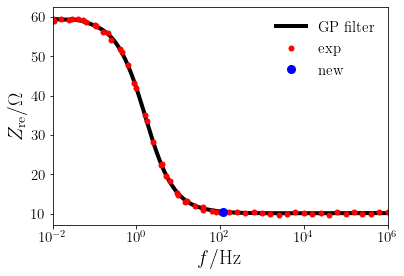

iter =  16 / 100 ; freq_new = 2.6585E+00


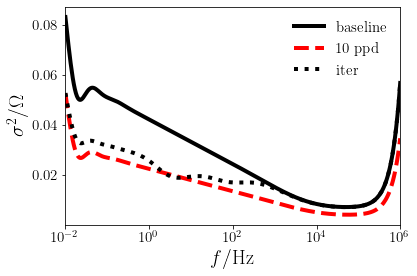

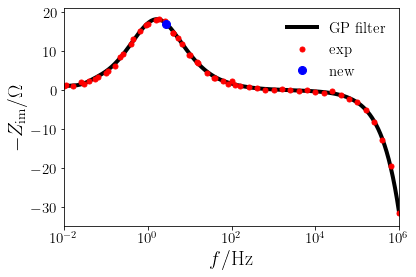

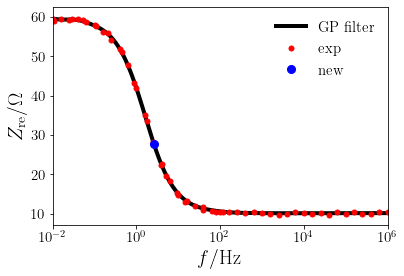

iter =  17 / 100 ; freq_new = 9.9994E+05


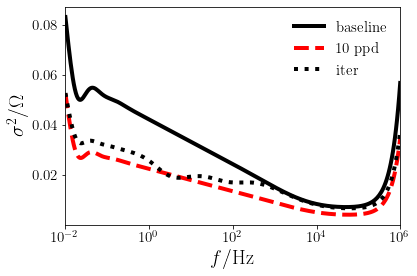

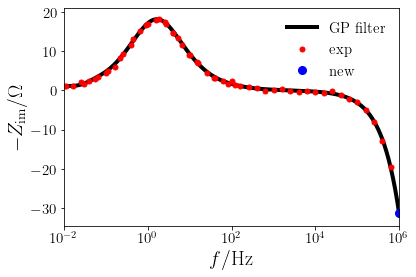

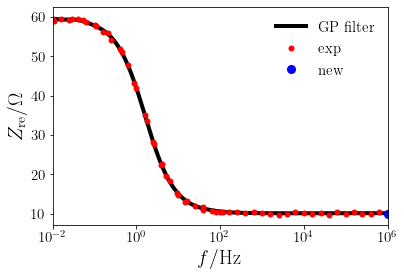

iter =  18 / 100 ; freq_new = 9.4094E+02


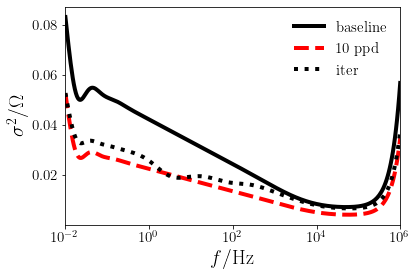

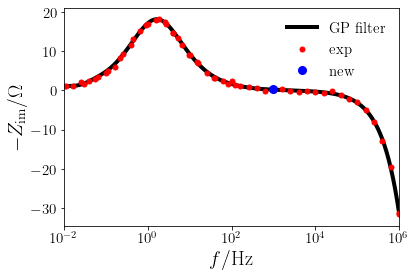

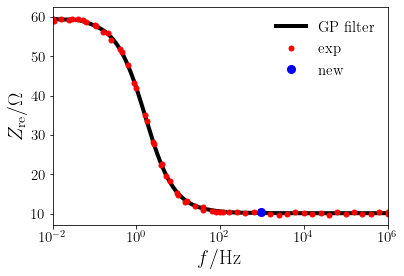

iter =  19 / 100 ; freq_new = 9.9954E+05


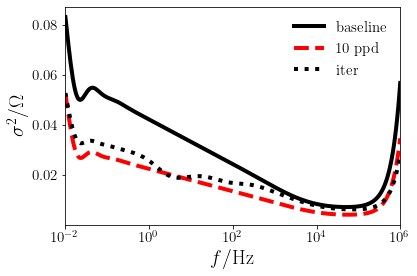

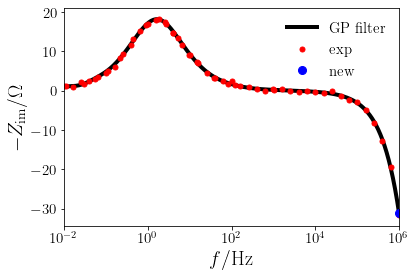

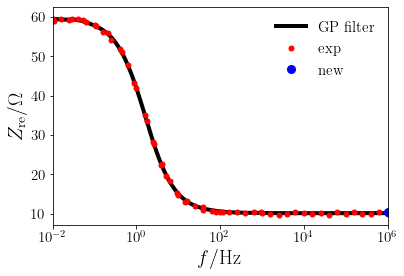

iter =  20 / 100 ; freq_new = 9.9914E+05


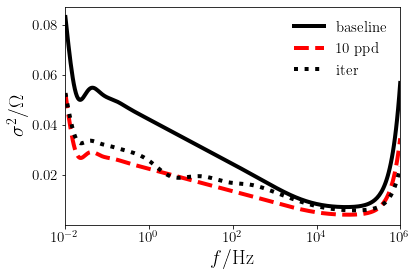

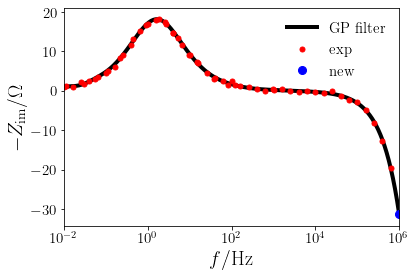

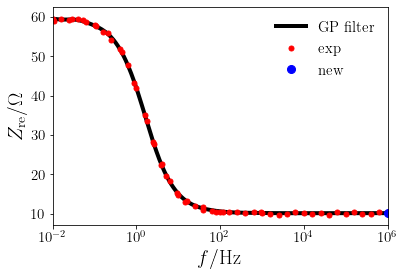

iter =  21 / 100 ; freq_new = 9.9802E+05


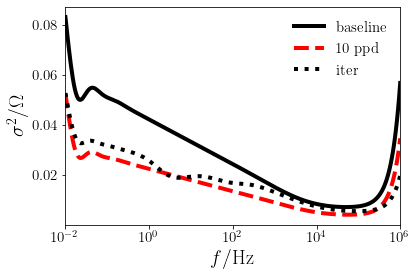

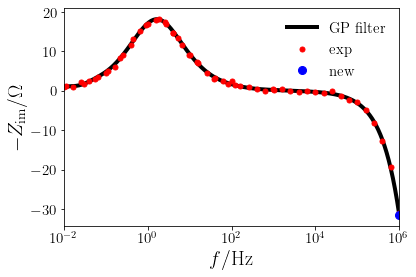

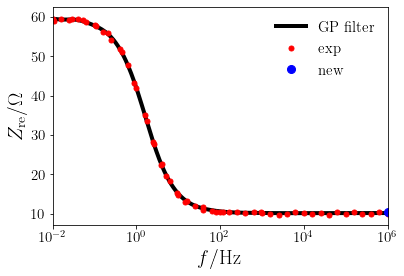

iter =  22 / 100 ; freq_new = 9.9851E+05


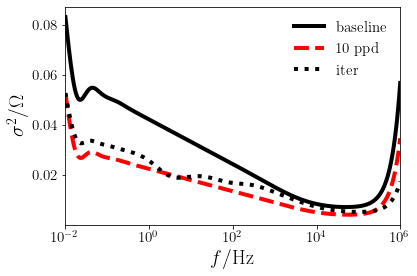

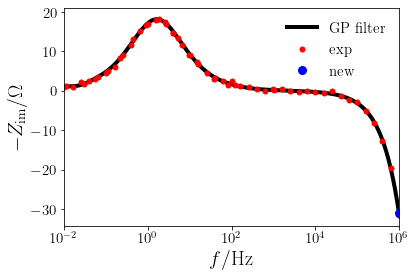

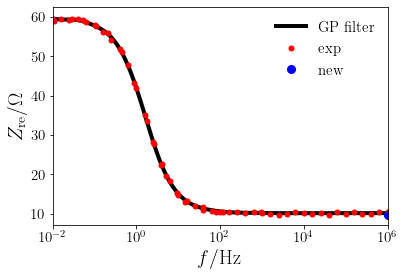

iter =  23 / 100 ; freq_new = 9.9768E+05


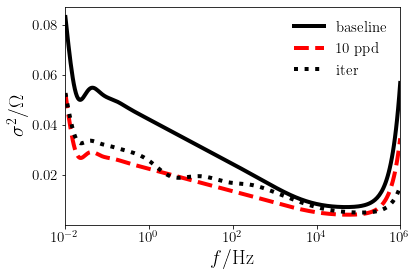

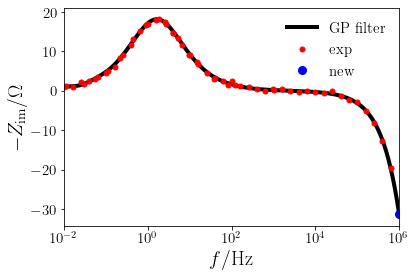

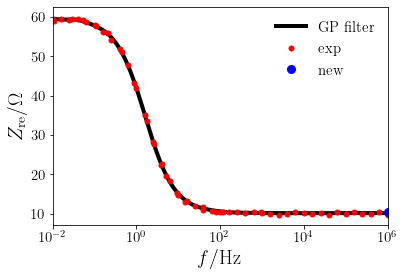

iter =  24 / 100 ; freq_new = 9.9837E+05


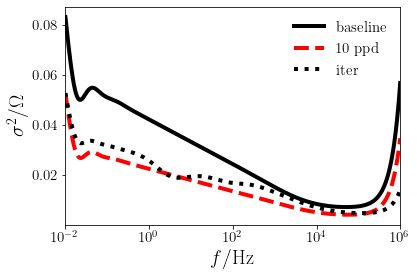

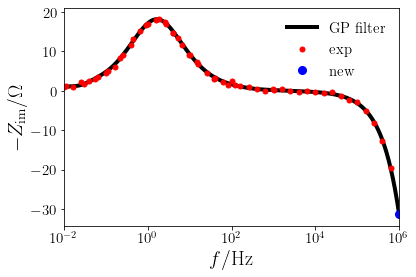

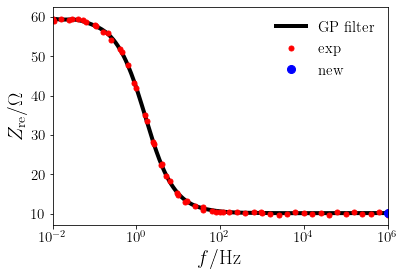

iter =  25 / 100 ; freq_new = 9.8282E+05


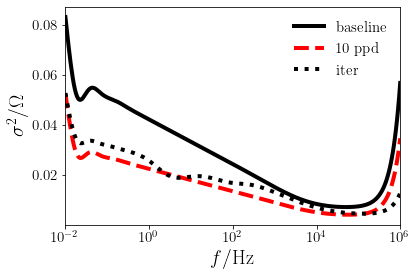

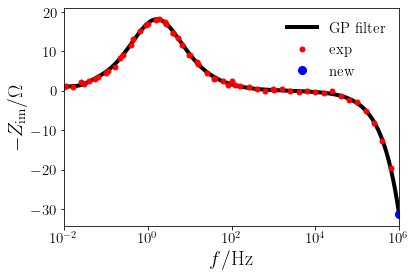

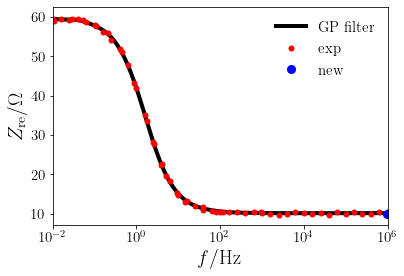

iter =  26 / 100 ; freq_new = 9.9881E+05


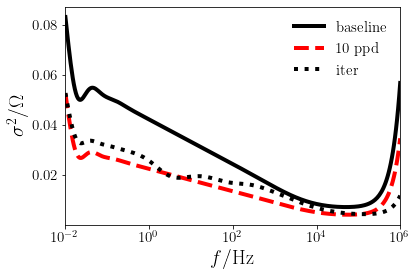

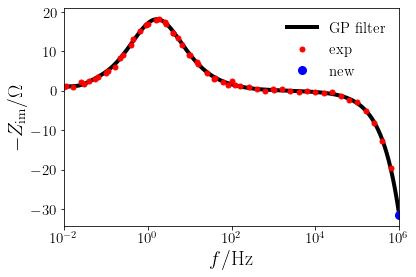

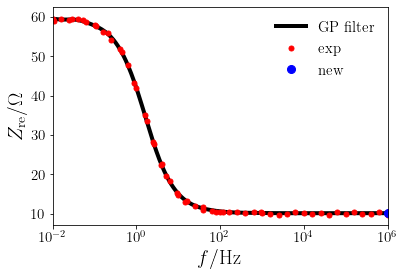

iter =  27 / 100 ; freq_new = 9.9631E+05


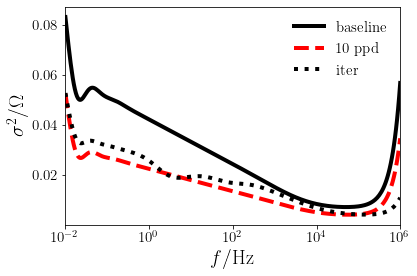

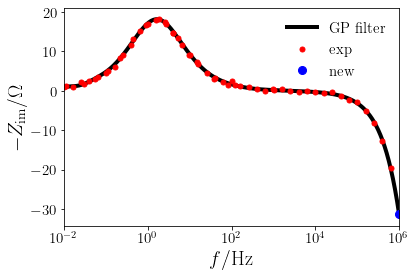

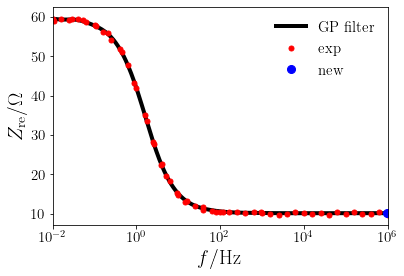

iter =  28 / 100 ; freq_new = 9.8872E+05


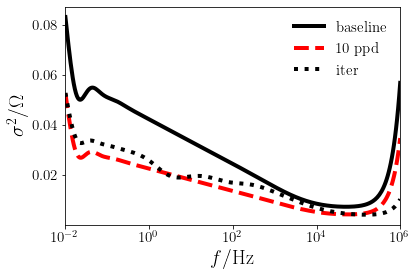

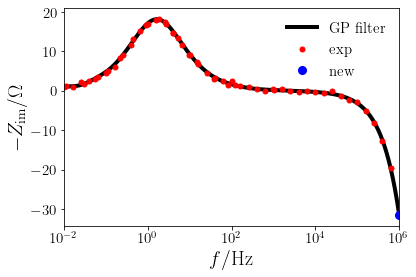

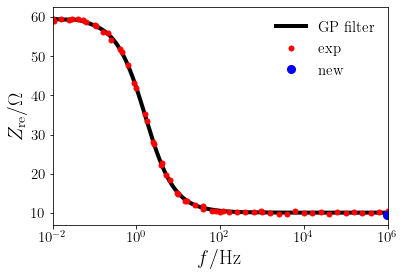

iter =  29 / 100 ; freq_new = 9.8586E+05


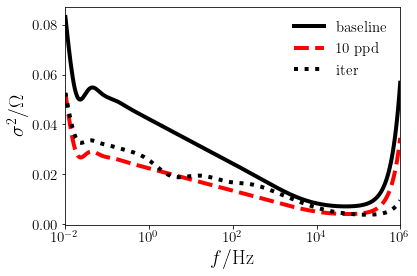

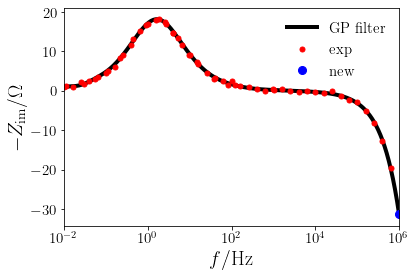

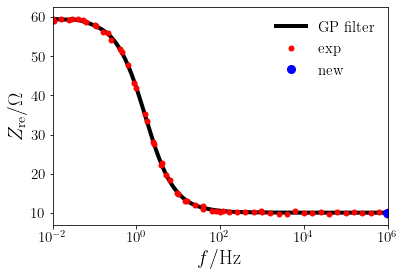

iter =  30 / 100 ; freq_new = 9.8707E+05


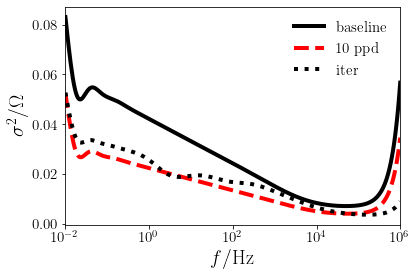

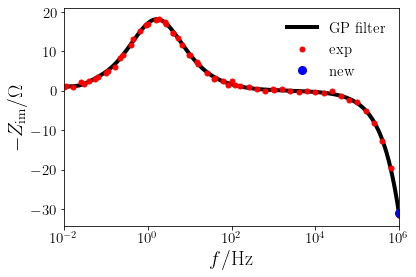

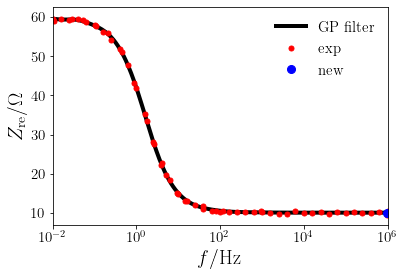

iter =  31 / 100 ; freq_new = 9.7387E+05
2.8171E-01, 2.6576E+01, 1.8624E+01, 2.7343E+01, 1.0085E+01, 4.997700E-06; evidence = -6.09844370E+01
2.8171E-01, 2.6576E+01, 2.1241E+01, 2.9961E+01, 1.0085E+01, 4.997700E-06; evidence = -6.09844370E+01
Optimization terminated successfully.
         Current function value: -60.984437
         Iterations: 2
         Function evaluations: 310


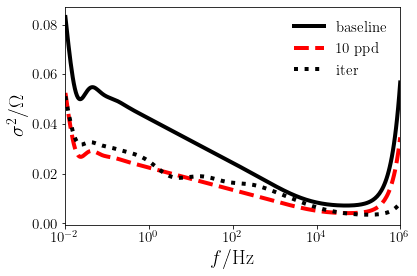

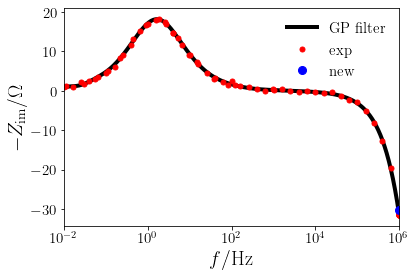

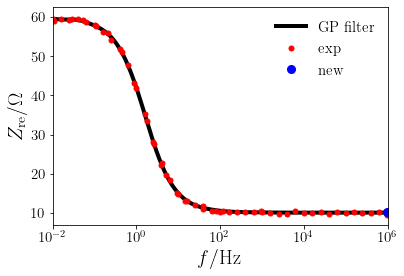

iter =  32 / 100 ; freq_new = 9.6052E+05


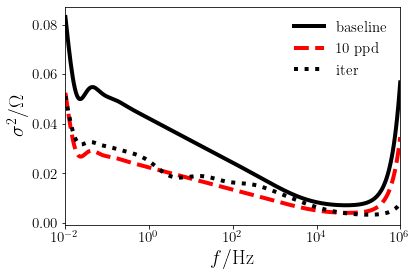

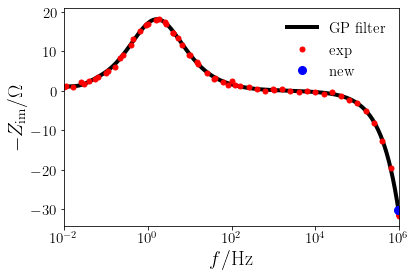

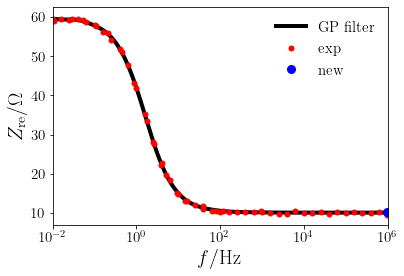

iter =  33 / 100 ; freq_new = 9.8970E+05


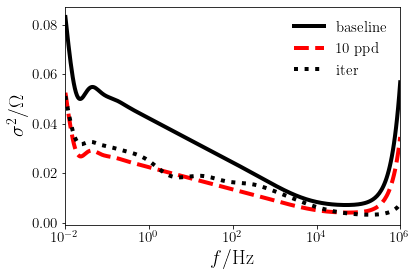

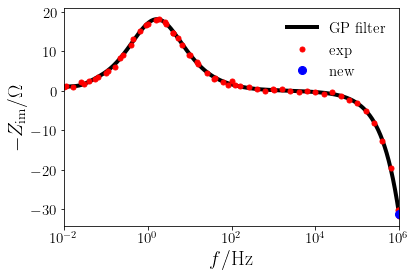

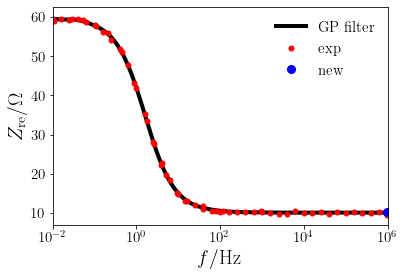

iter =  34 / 100 ; freq_new = 9.3767E+05


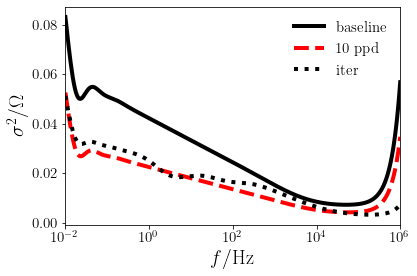

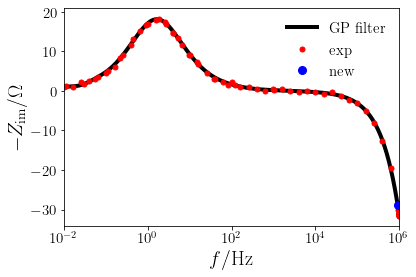

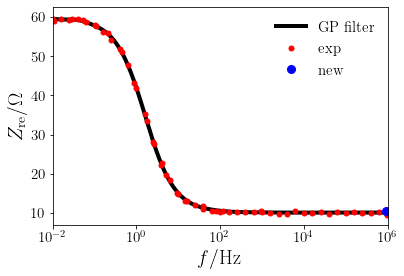

iter =  35 / 100 ; freq_new = 8.9942E+05


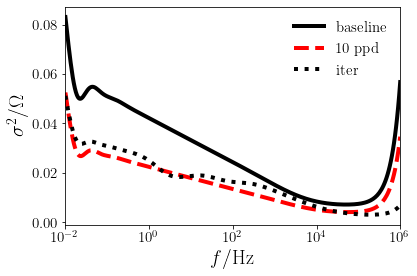

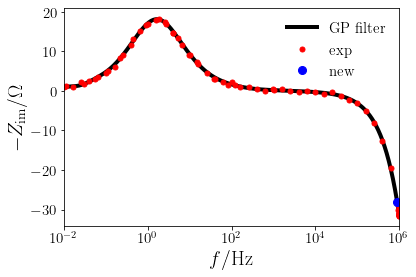

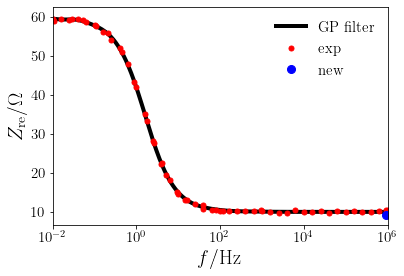

iter =  36 / 100 ; freq_new = 9.0602E+05


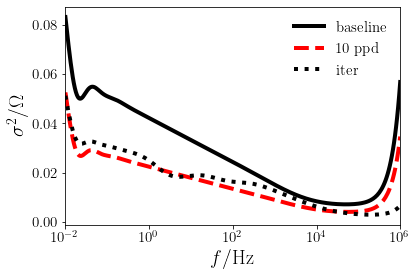

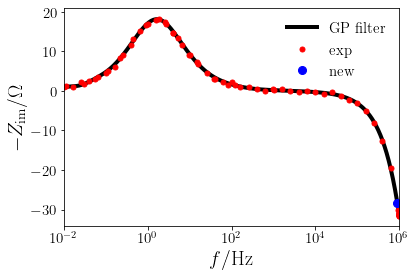

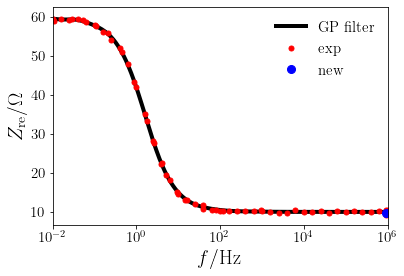

iter =  37 / 100 ; freq_new = 9.4268E+05


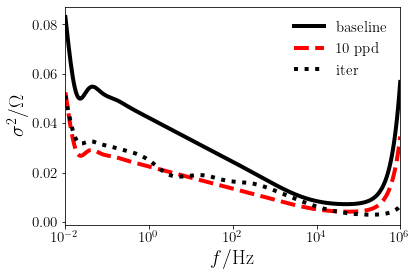

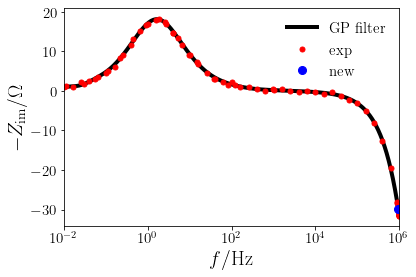

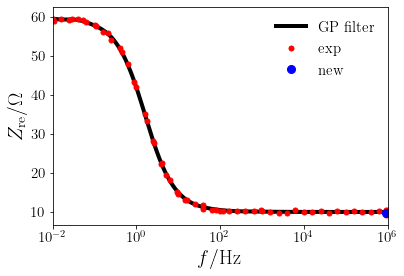

iter =  38 / 100 ; freq_new = 9.4862E+05


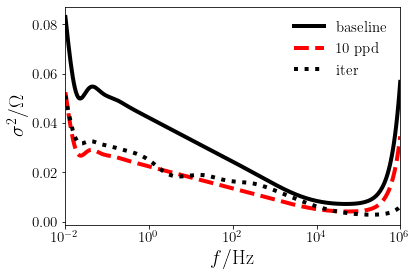

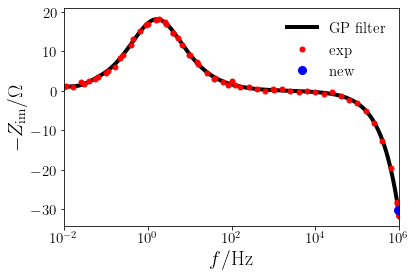

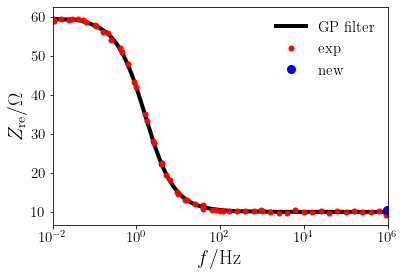

iter =  39 / 100 ; freq_new = 8.3097E+05


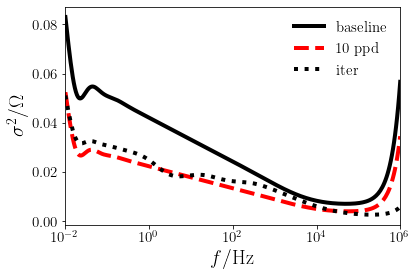

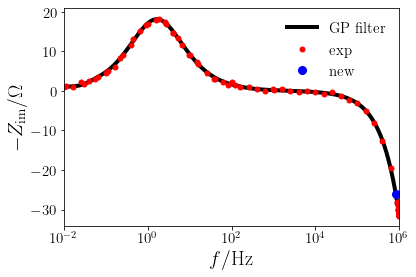

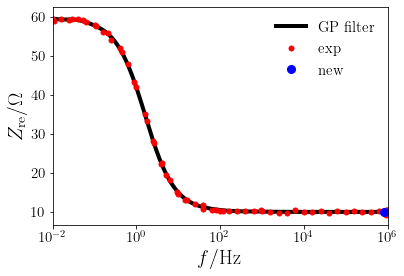

iter =  40 / 100 ; freq_new = 9.6803E+05


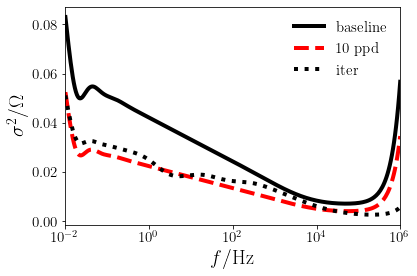

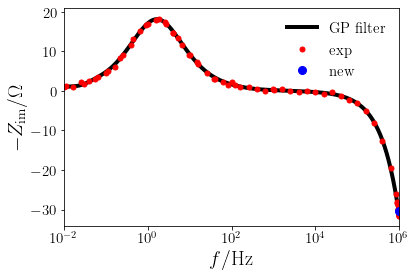

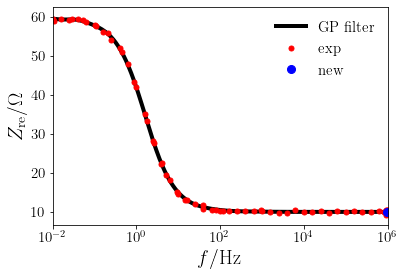

iter =  41 / 100 ; freq_new = 9.9313E+05


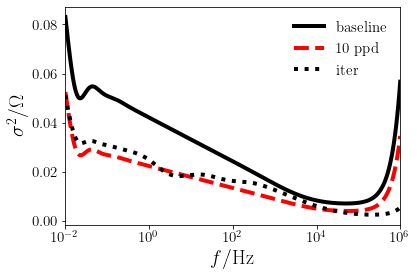

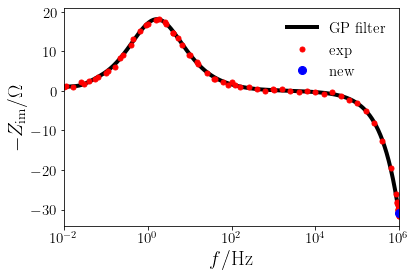

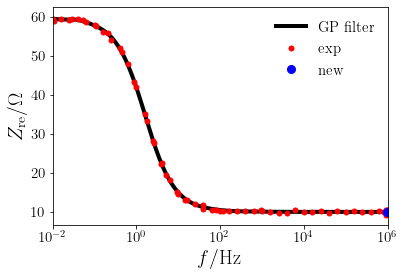

iter =  42 / 100 ; freq_new = 9.2574E+05


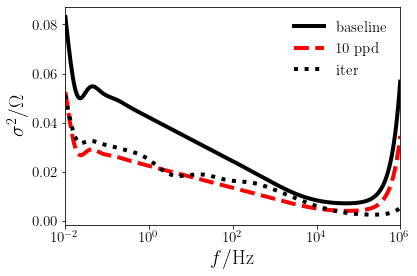

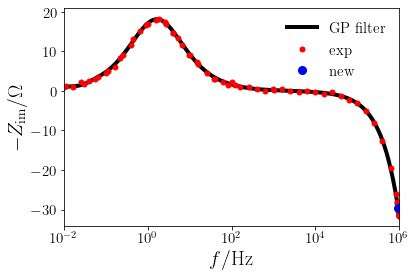

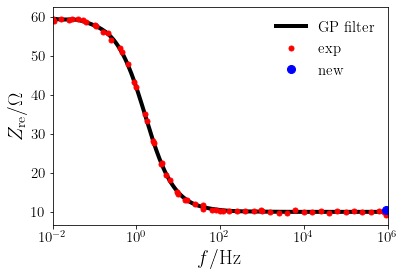

iter =  43 / 100 ; freq_new = 9.5136E+05


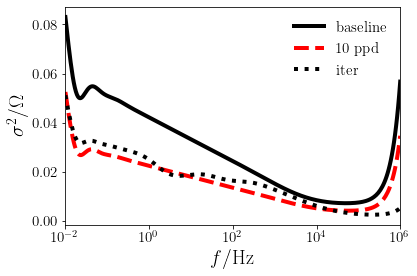

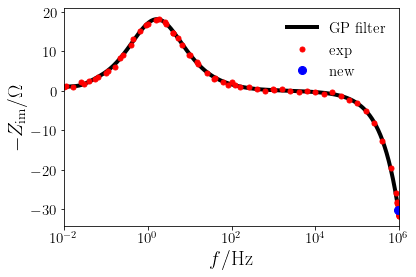

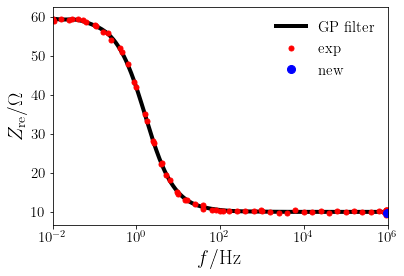

iter =  44 / 100 ; freq_new = 8.1401E+05


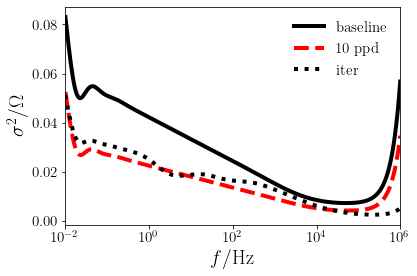

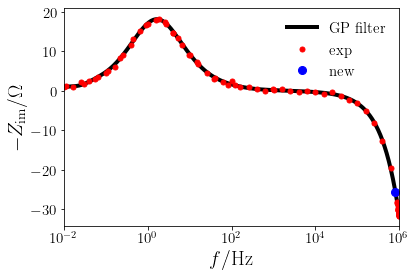

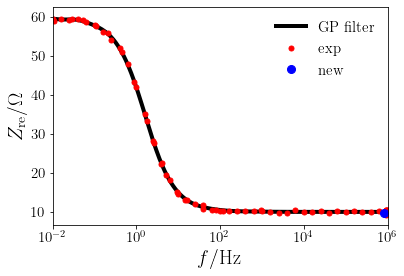

iter =  45 / 100 ; freq_new = 6.4760E+05


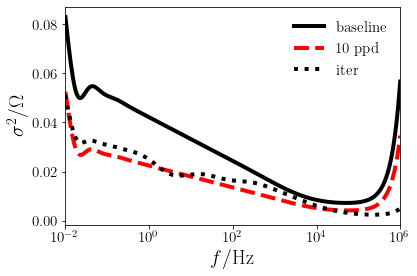

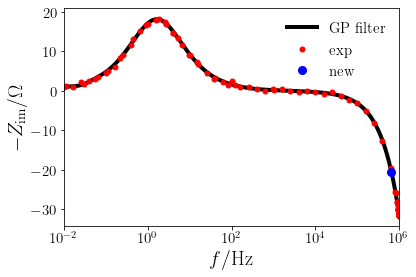

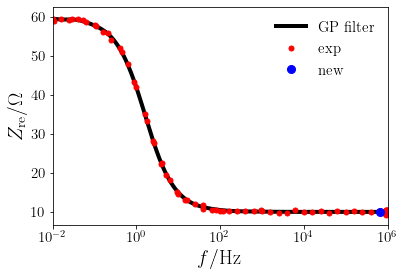

iter =  46 / 100 ; freq_new = 8.6392E+05


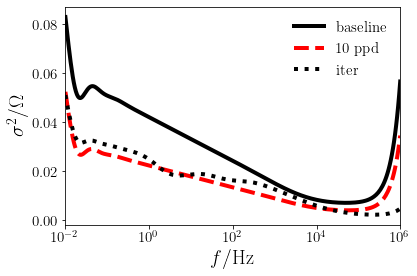

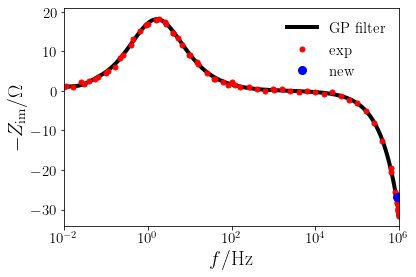

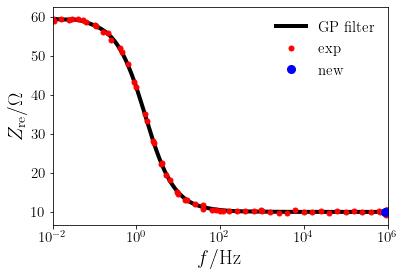

iter =  47 / 100 ; freq_new = 8.5321E+05


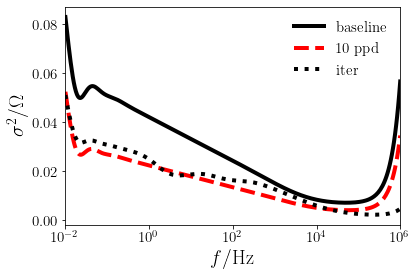

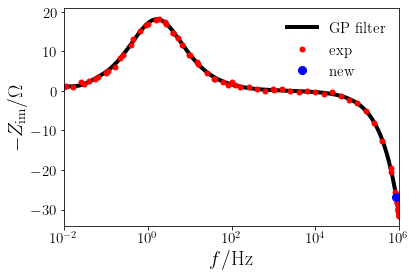

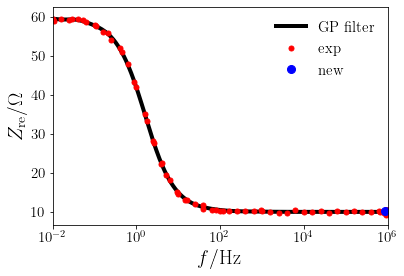

iter =  48 / 100 ; freq_new = 9.2675E+05


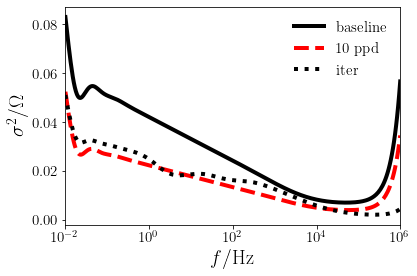

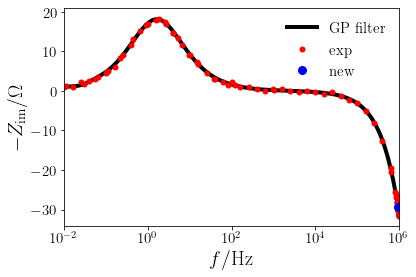

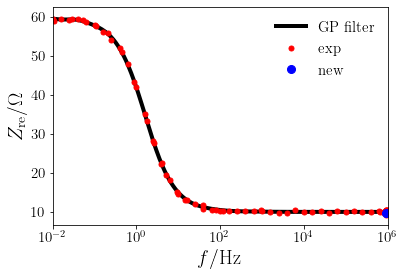

iter =  49 / 100 ; freq_new = 9.2651E+05


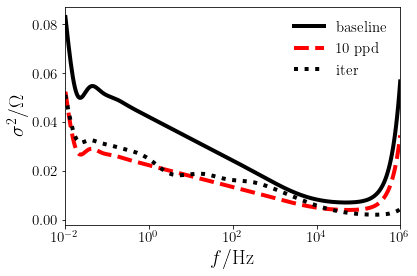

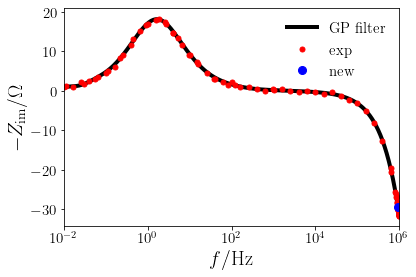

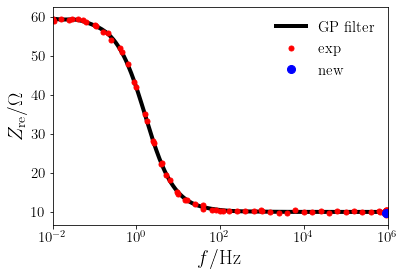

iter =  50 / 100 ; freq_new = 9.8162E+05


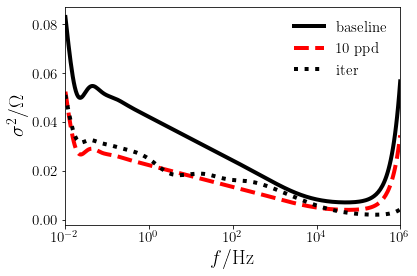

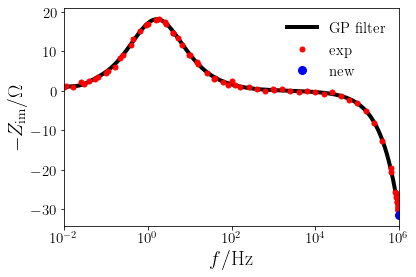

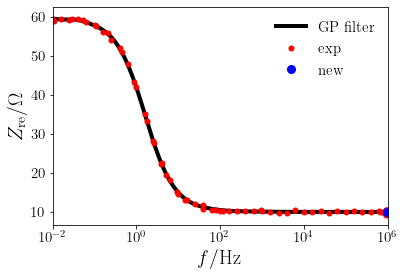

iter =  51 / 100 ; freq_new = 9.6499E+05


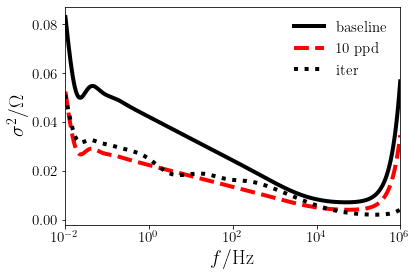

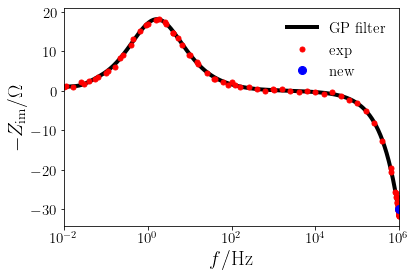

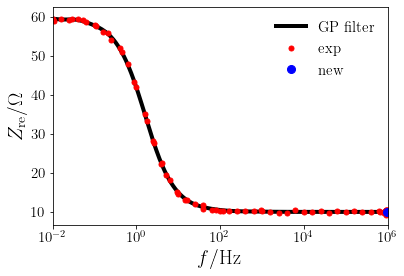

iter =  52 / 100 ; freq_new = 9.5556E+05


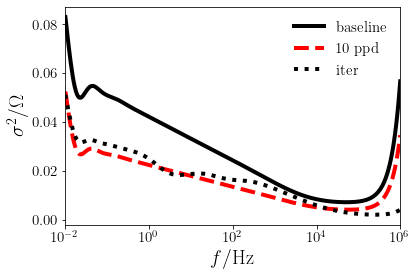

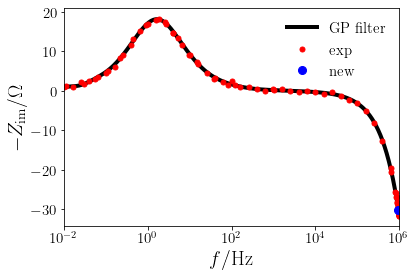

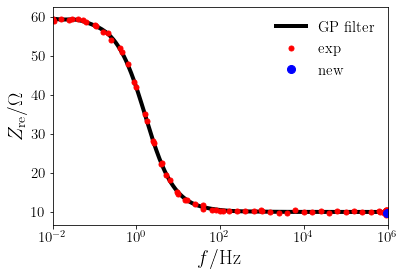

iter =  53 / 100 ; freq_new = 9.8769E+05


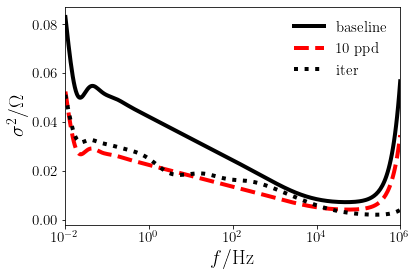

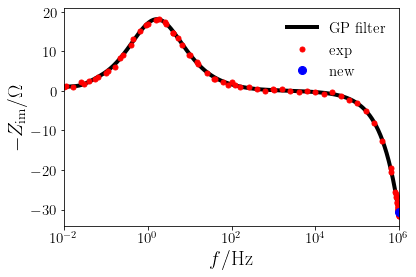

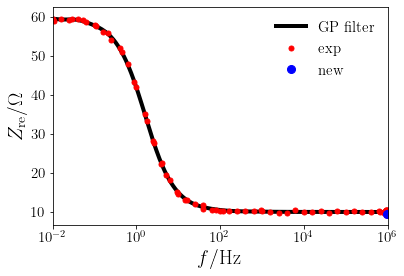

iter =  54 / 100 ; freq_new = 9.8477E+05


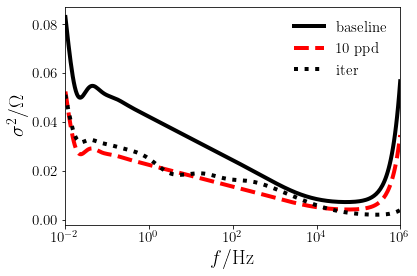

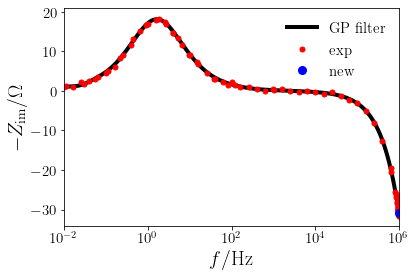

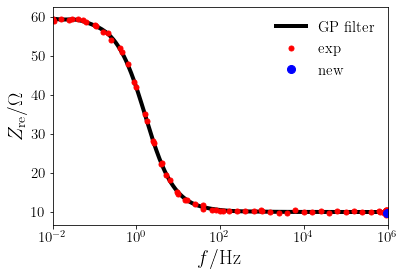

iter =  55 / 100 ; freq_new = 9.9837E+05


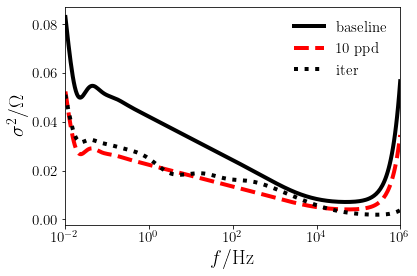

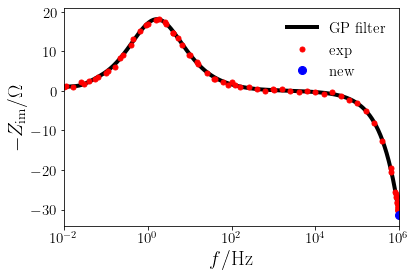

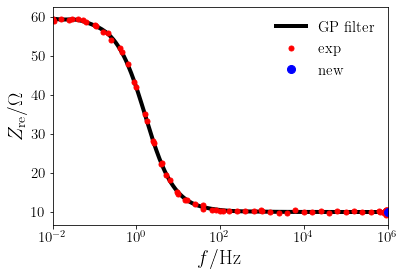

iter =  56 / 100 ; freq_new = 9.9837E+05


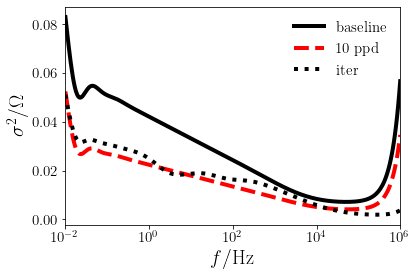

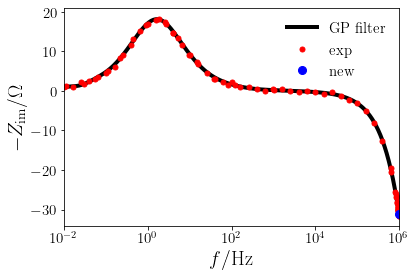

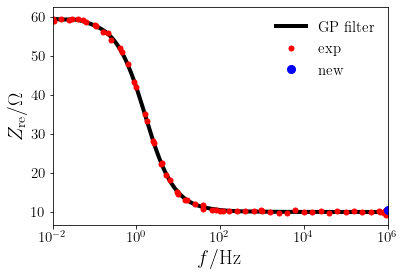

iter =  57 / 100 ; freq_new = 9.9937E+05


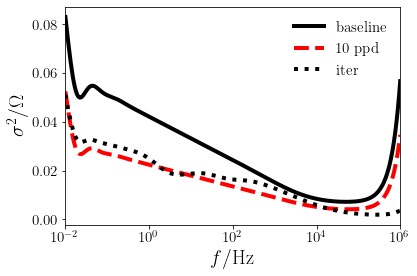

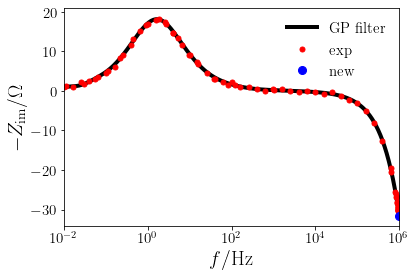

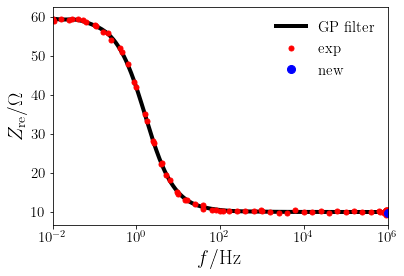

iter =  58 / 100 ; freq_new = 9.9985E+05


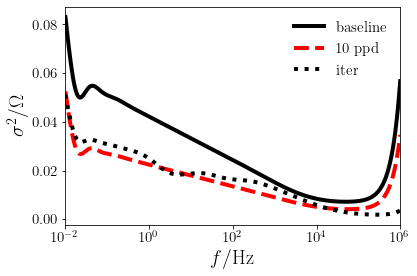

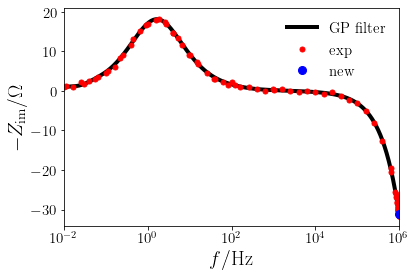

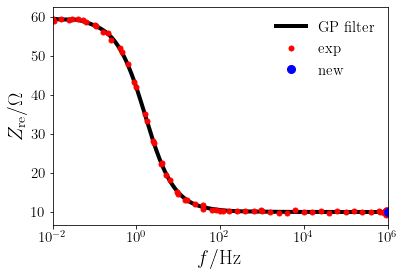

iter =  59 / 100 ; freq_new = 9.9991E+05


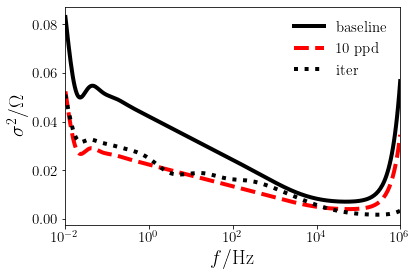

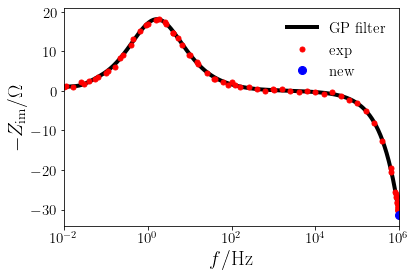

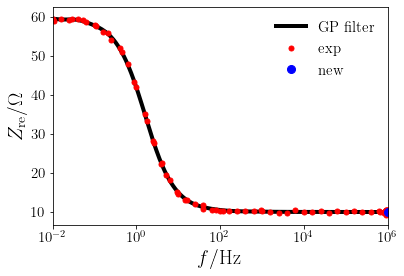

iter =  60 / 100 ; freq_new = 9.9995E+05


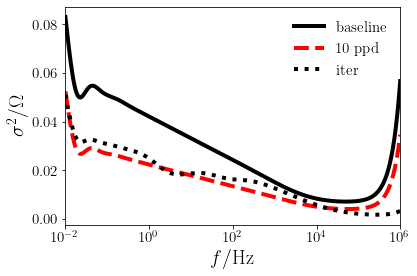

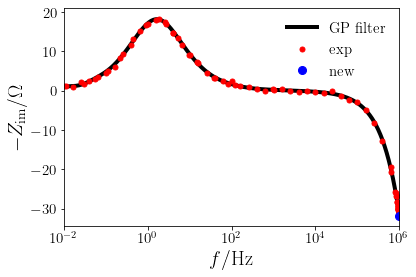

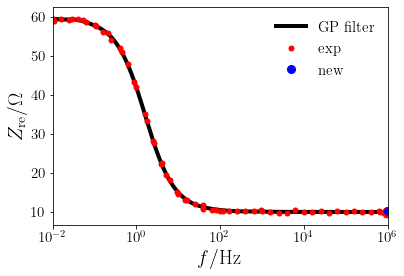

iter =  61 / 100 ; freq_new = 9.9999E+05


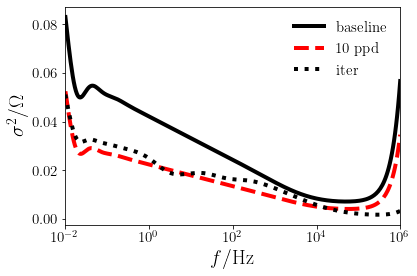

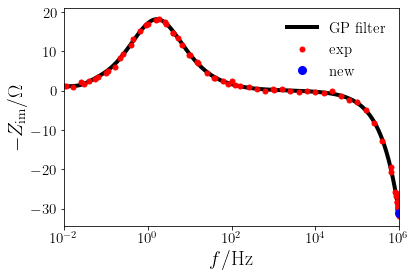

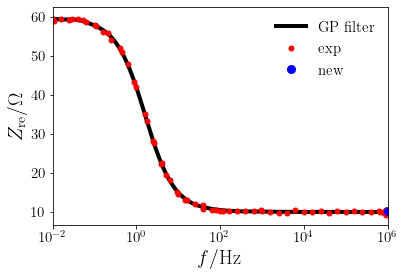

iter =  62 / 100 ; freq_new = 9.9994E+05


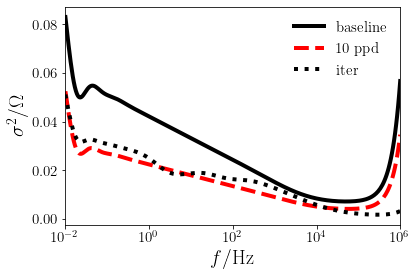

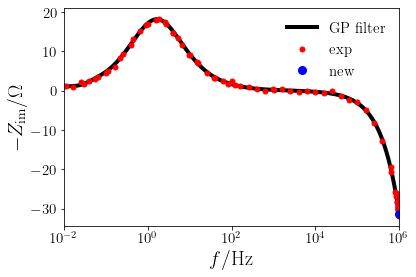

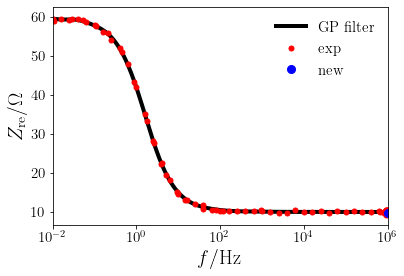

iter =  63 / 100 ; freq_new = 9.9999E+05


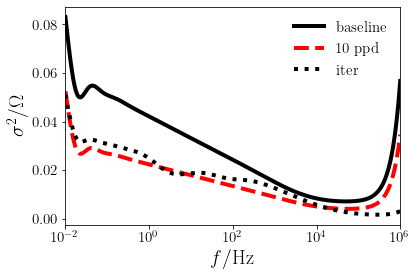

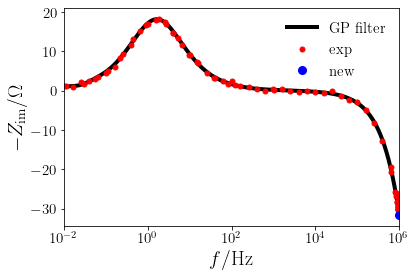

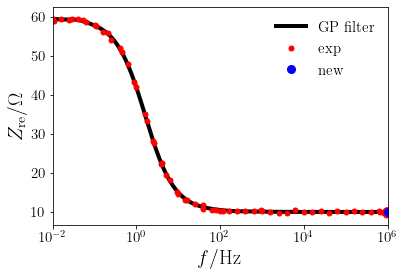

iter =  64 / 100 ; freq_new = 1.0000E+06


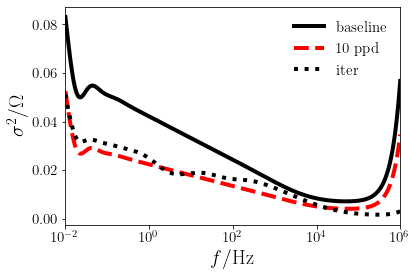

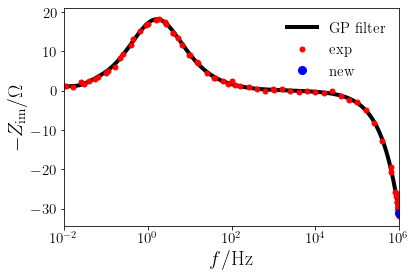

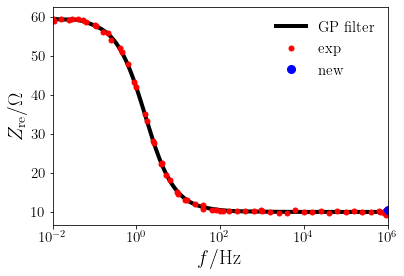

iter =  65 / 100 ; freq_new = 1.0000E+06


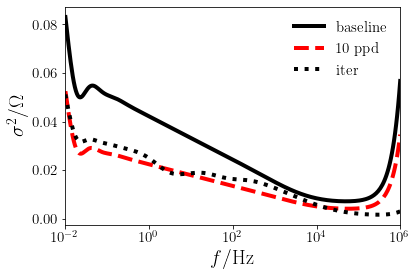

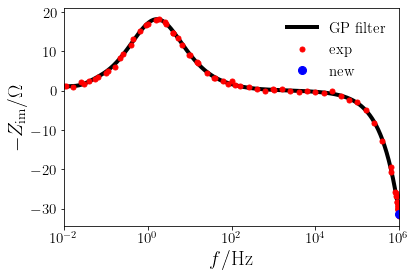

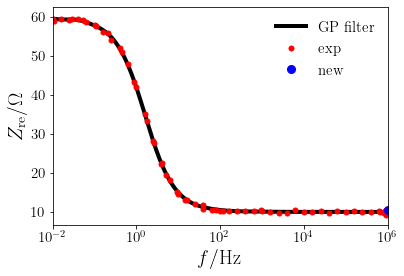

iter =  66 / 100 ; freq_new = 1.0000E+06


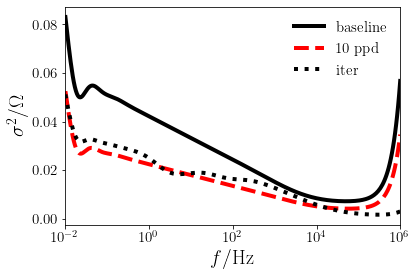

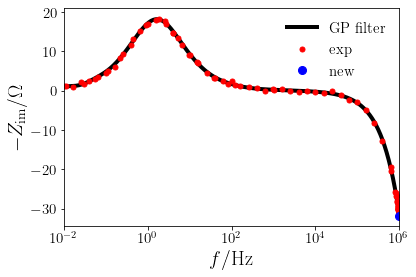

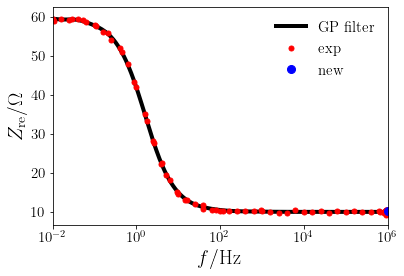

iter =  67 / 100 ; freq_new = 1.0000E+06


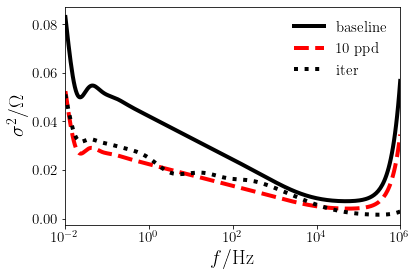

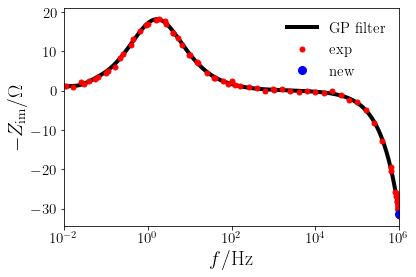

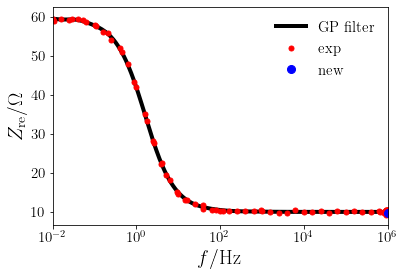

iter =  68 / 100 ; freq_new = 1.0000E+06


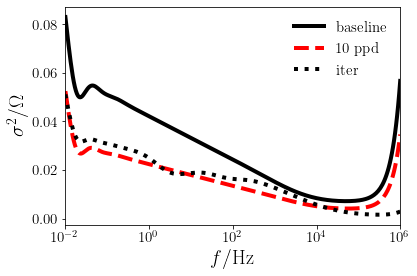

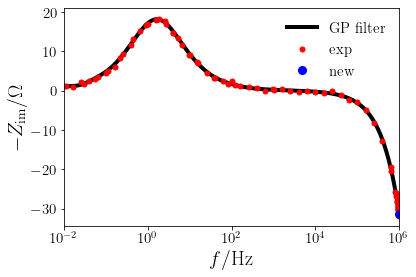

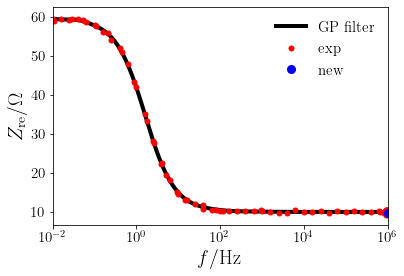

iter =  69 / 100 ; freq_new = 1.0000E+06


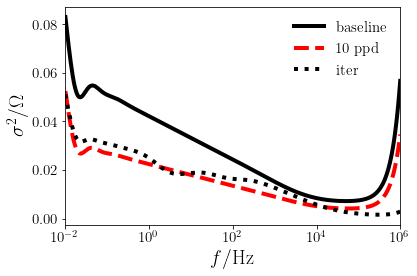

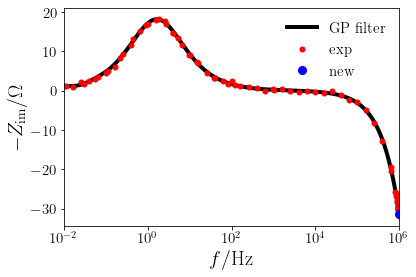

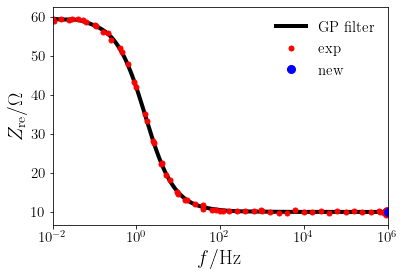

iter =  70 / 100 ; freq_new = 1.0000E+06


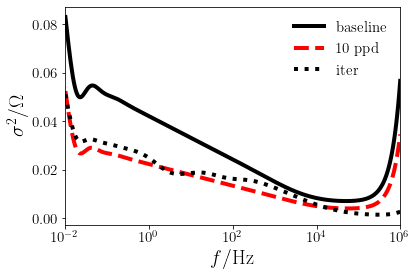

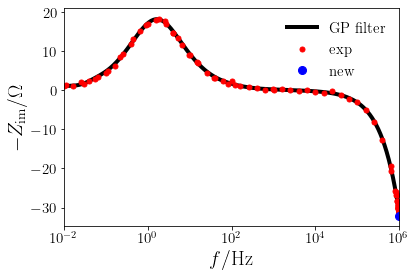

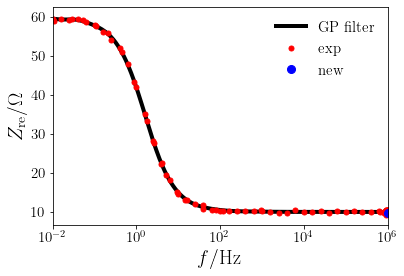

iter =  71 / 100 ; freq_new = 1.0000E+06


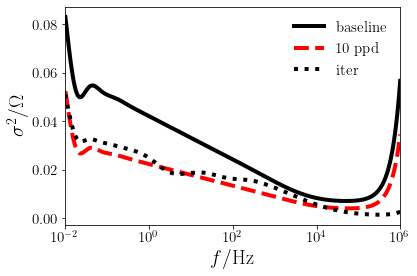

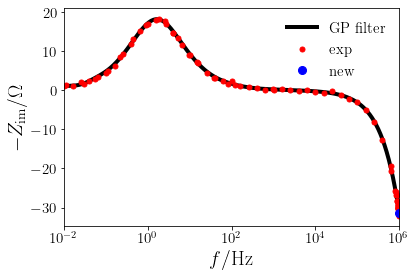

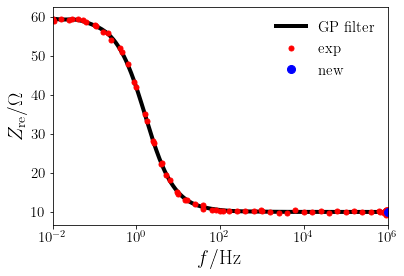

iter =  72 / 100 ; freq_new = 1.0000E+06


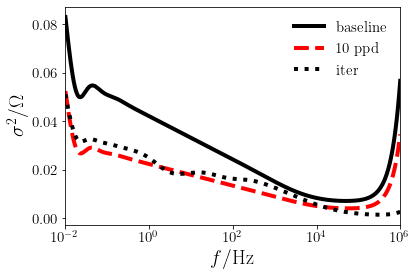

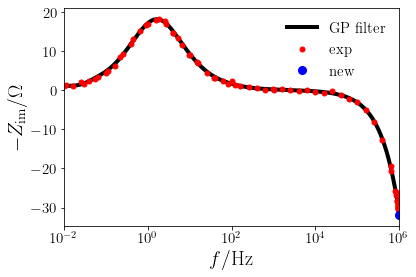

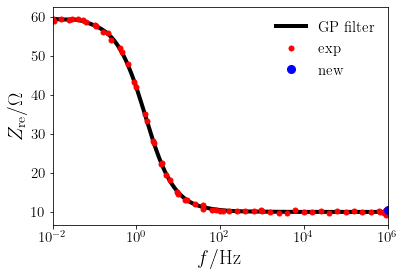

iter =  73 / 100 ; freq_new = 5.9177E+05


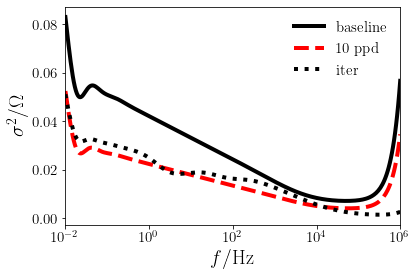

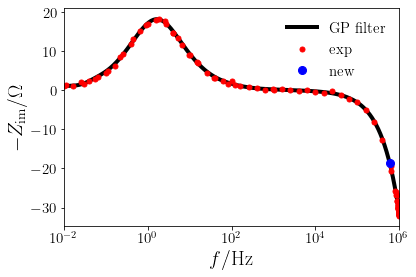

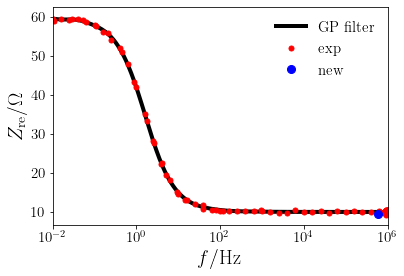

iter =  74 / 100 ; freq_new = 5.8634E+05


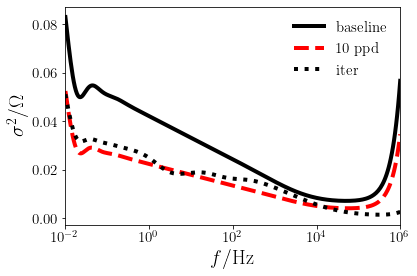

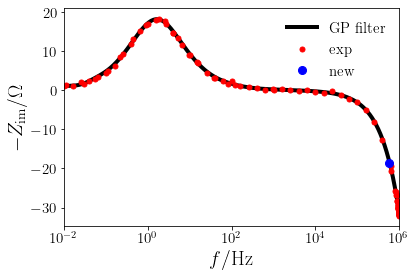

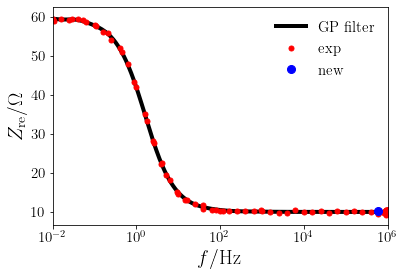

iter =  75 / 100 ; freq_new = 6.5156E+05


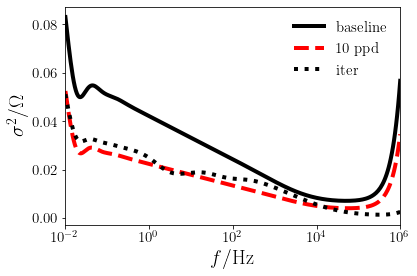

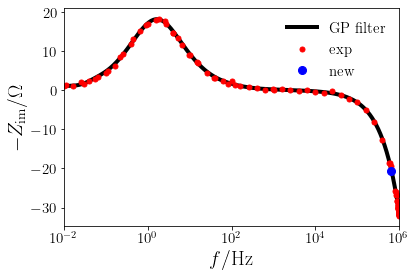

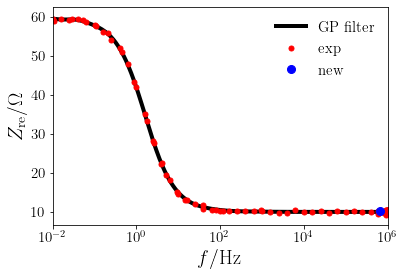

iter =  76 / 100 ; freq_new = 9.0119E+05


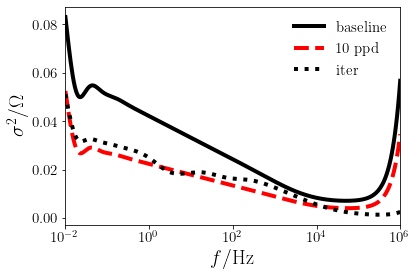

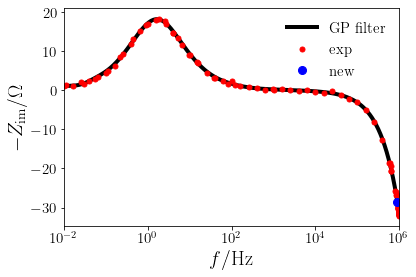

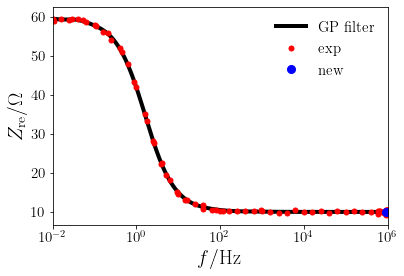

iter =  77 / 100 ; freq_new = 7.4646E+05


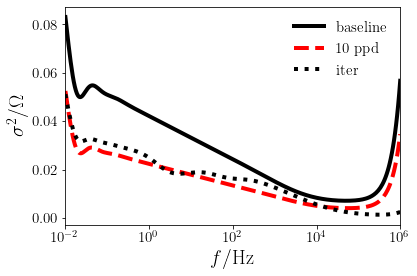

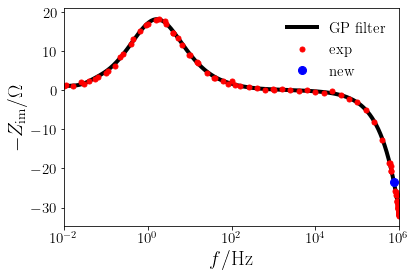

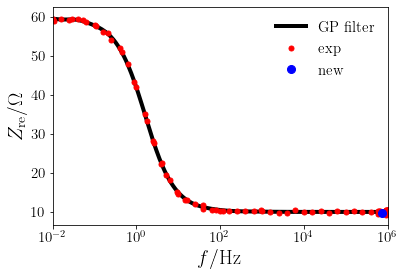

iter =  78 / 100 ; freq_new = 7.1187E+05


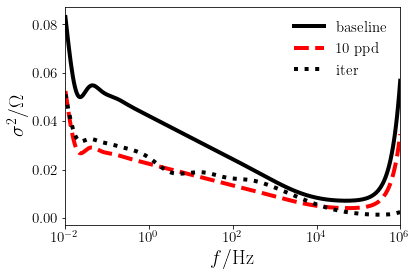

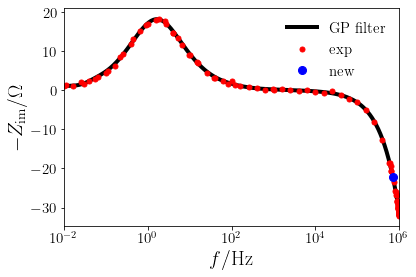

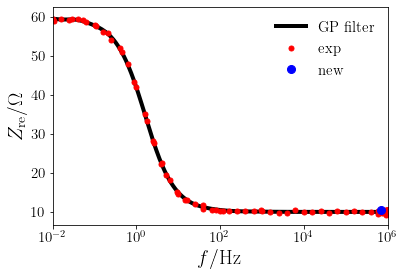

iter =  79 / 100 ; freq_new = 6.2682E+05


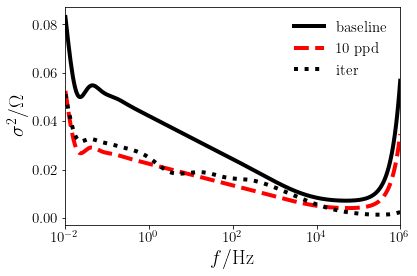

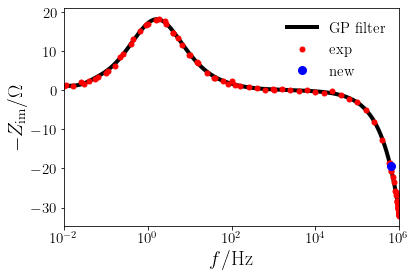

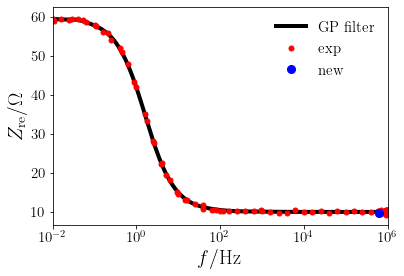

iter =  80 / 100 ; freq_new = 7.6430E+05


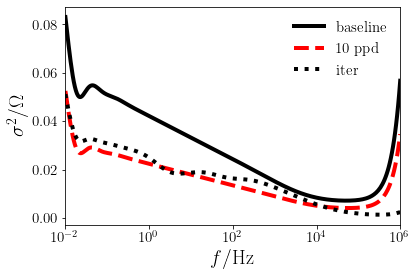

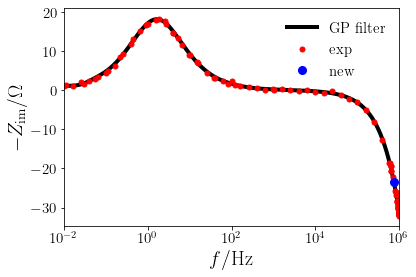

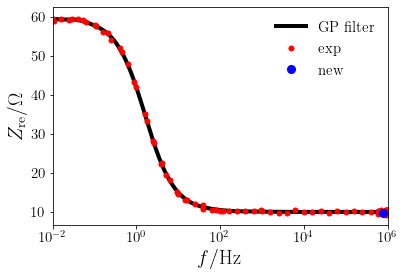

iter =  81 / 100 ; freq_new = 7.8593E+05


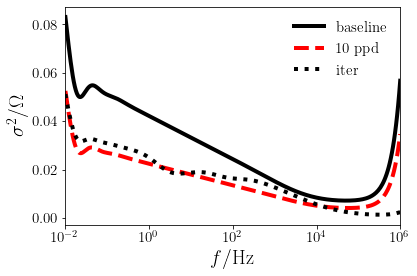

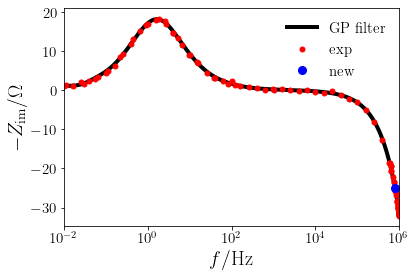

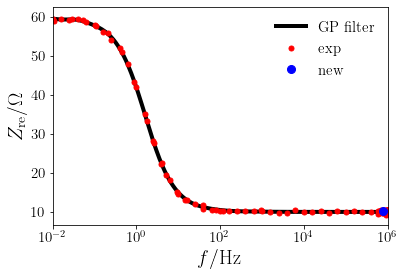

iter =  82 / 100 ; freq_new = 8.4905E+05


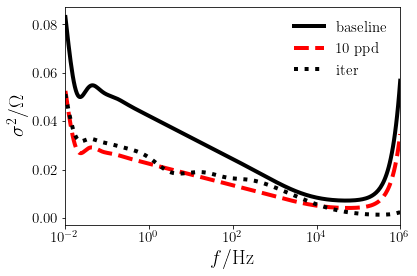

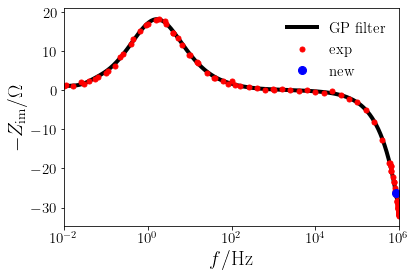

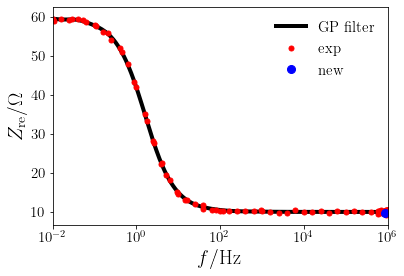

iter =  83 / 100 ; freq_new = 6.1036E+05


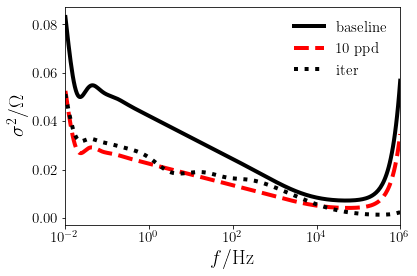

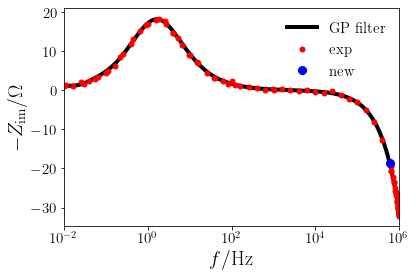

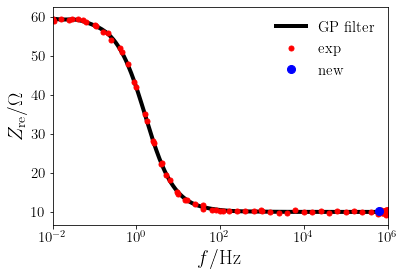

iter =  84 / 100 ; freq_new = 6.6430E+05


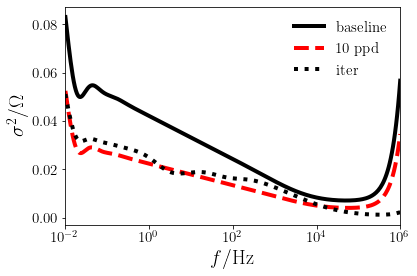

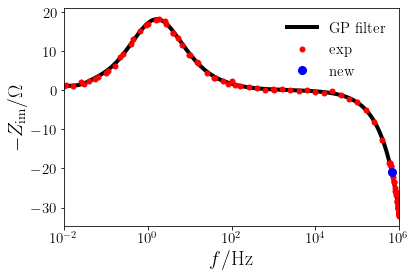

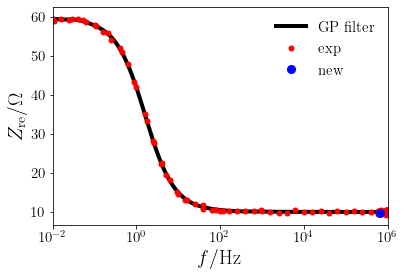

iter =  85 / 100 ; freq_new = 6.5373E+05


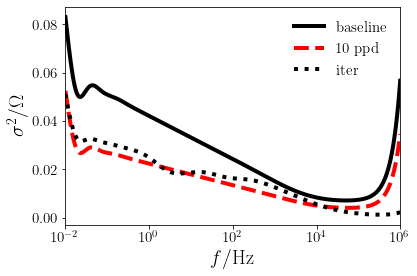

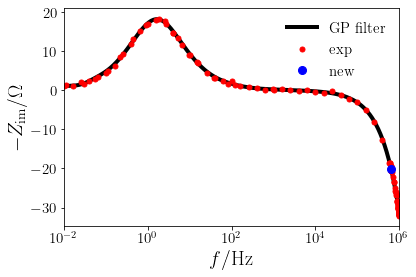

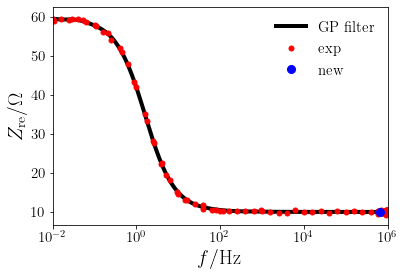

iter =  86 / 100 ; freq_new = 6.5190E+05


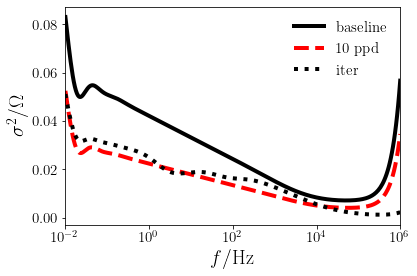

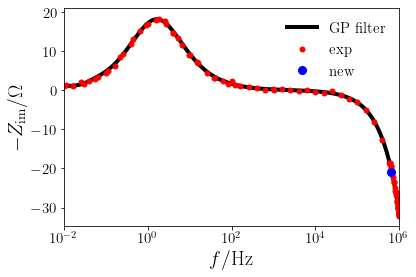

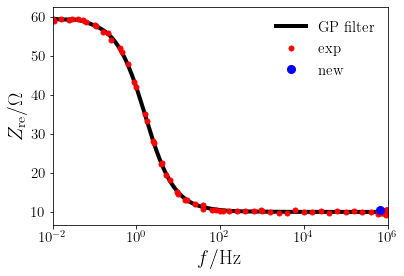

iter =  87 / 100 ; freq_new = 7.2573E+05


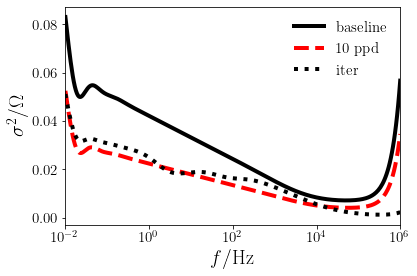

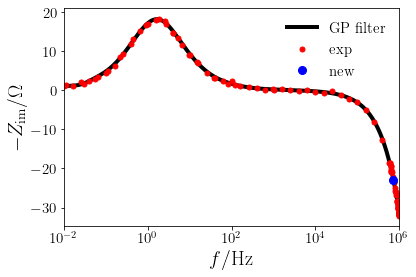

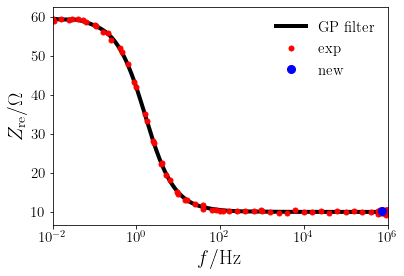

iter =  88 / 100 ; freq_new = 8.3662E+05


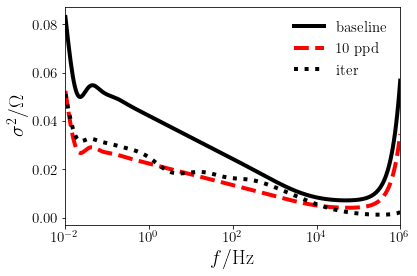

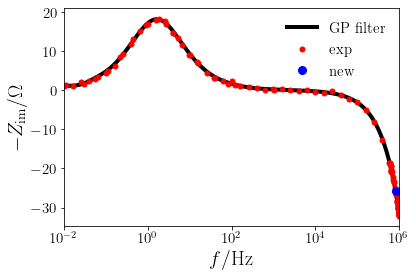

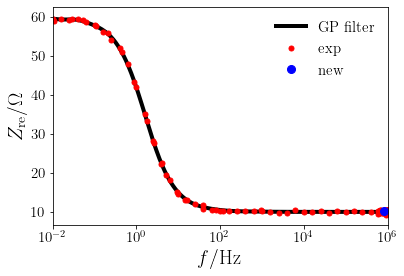

iter =  89 / 100 ; freq_new = 7.7397E+05


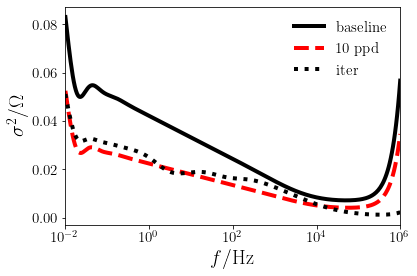

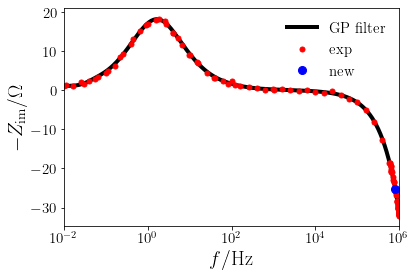

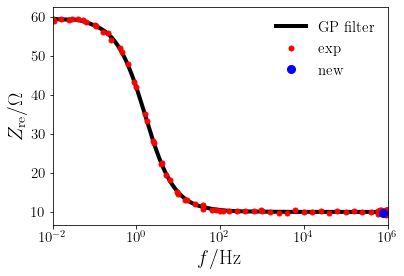

iter =  90 / 100 ; freq_new = 6.5021E+05


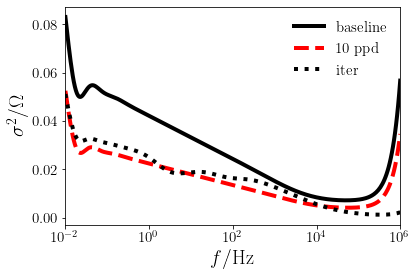

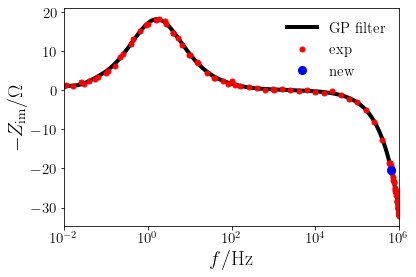

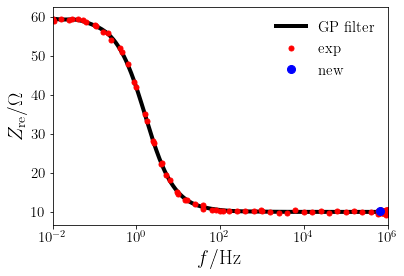

iter =  91 / 100 ; freq_new = 8.0195E+05


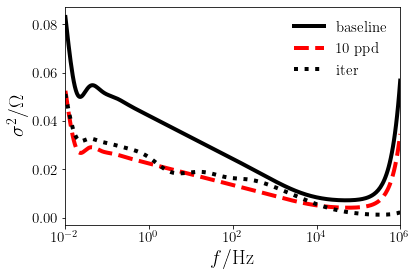

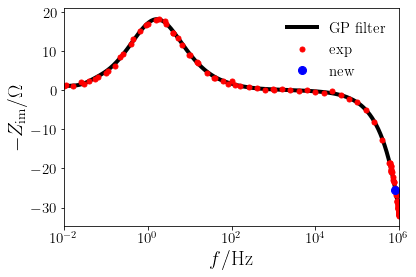

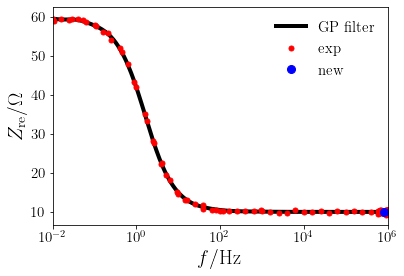

iter =  92 / 100 ; freq_new = 6.5156E+05


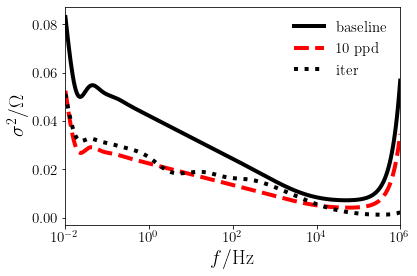

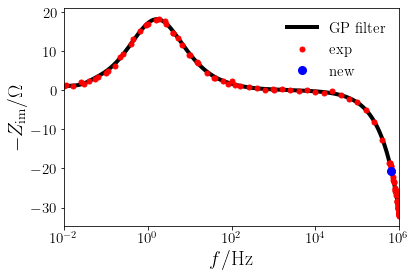

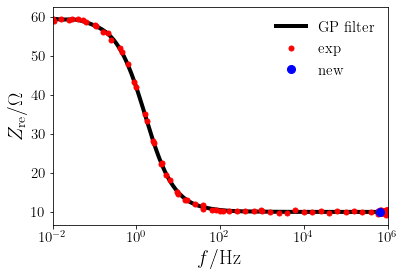

iter =  93 / 100 ; freq_new = 6.6739E+05


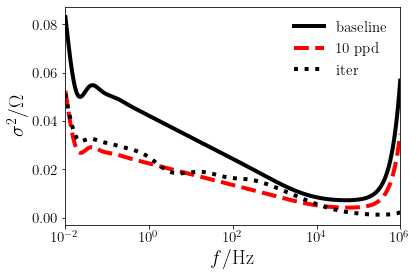

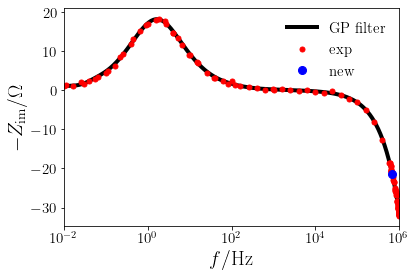

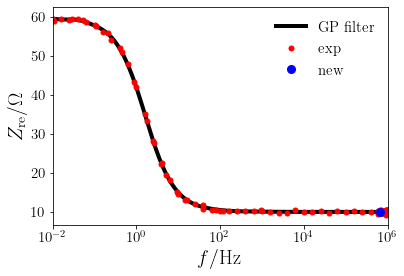

iter =  94 / 100 ; freq_new = 6.6862E+05


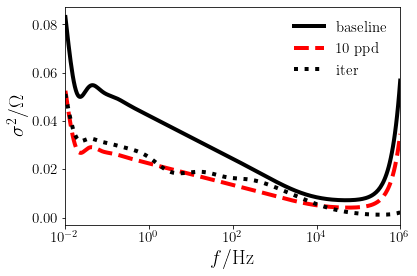

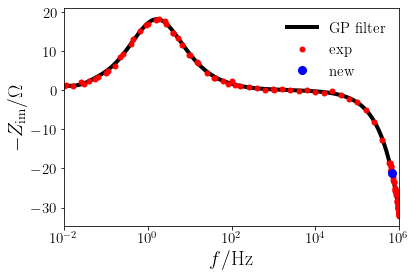

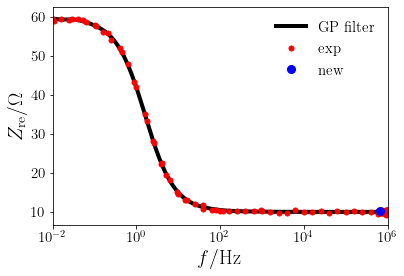

iter =  95 / 100 ; freq_new = 6.3235E+05


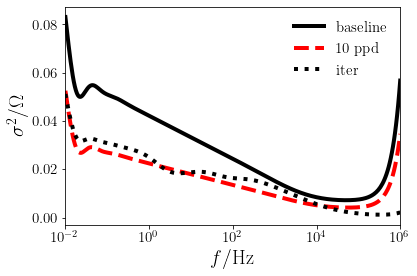

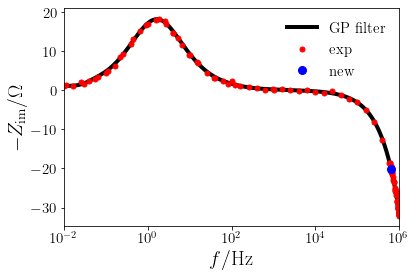

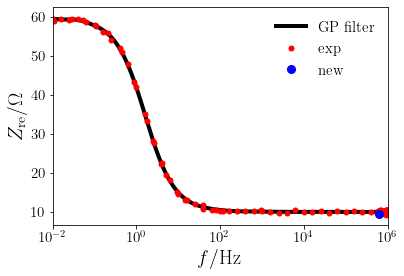

iter =  96 / 100 ; freq_new = 6.5155E+05


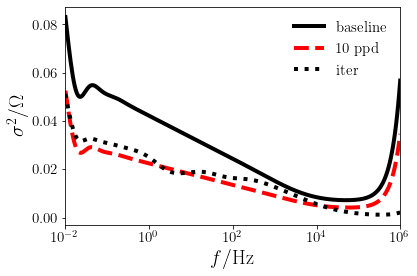

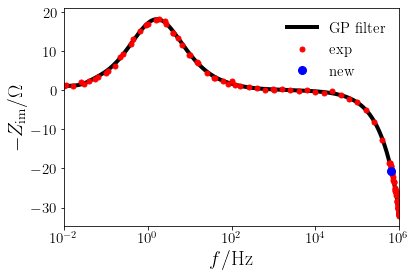

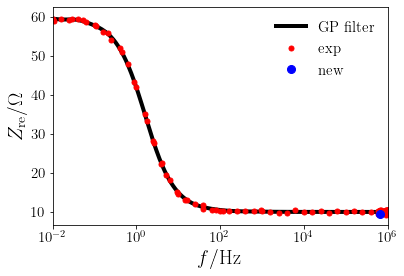

iter =  97 / 100 ; freq_new = 7.8706E+05


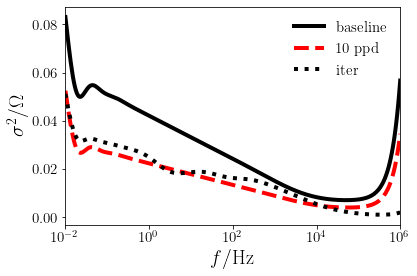

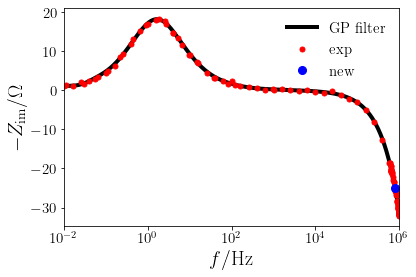

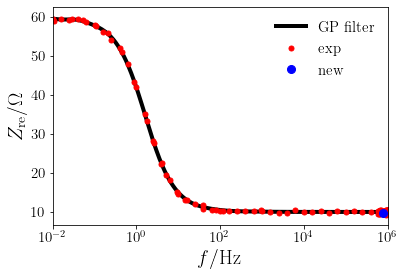

iter =  98 / 100 ; freq_new = 6.5245E+05


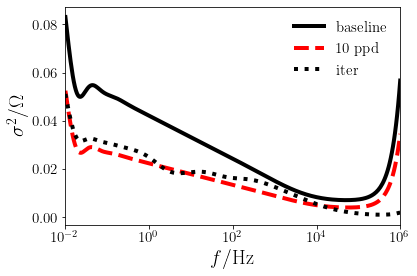

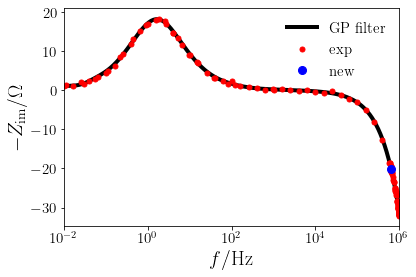

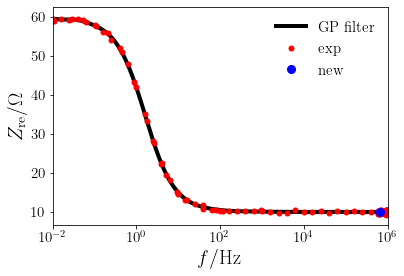

iter =  99 / 100 ; freq_new = 5.9560E+05


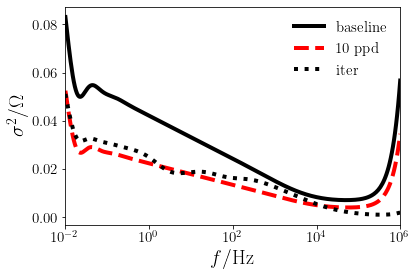

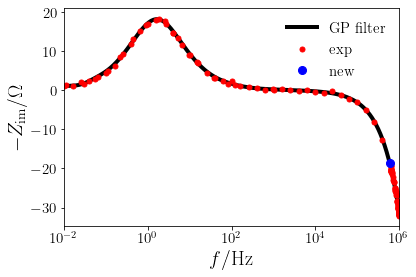

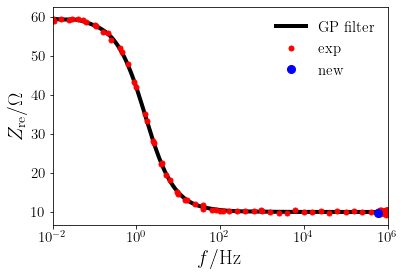

iter =  100 / 100 ; freq_new = 6.1630E+05


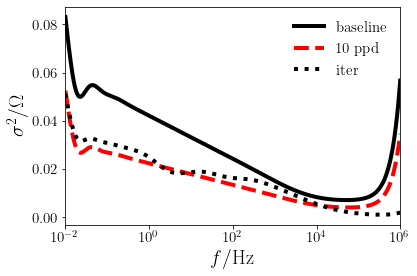

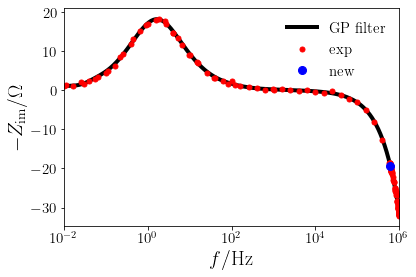

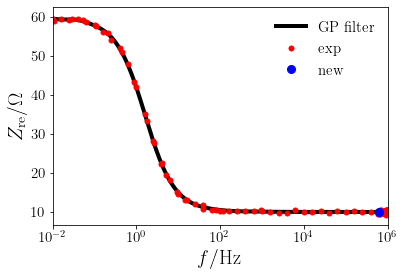

In [47]:
for iter in range(iter_max):

    excess_T = 0.90*T_10_ppd - T_N - (iter_max-iter)*1E-6

    if excess_T>0:

        freq_lb = max(1E-2, 1.0/excess_T )
        
        if freq_lb>=1E6:
            freq_lb = 5E5
            
    else:
        freq_lb = 5E5
        
    # find optimal frequency
    minimum = minimize_scalar(gpf.compute_ALC, bounds=(log10(freq_lb), 6), \
                                       method='bounded', args = (theta_N, ker_opts_N, freq_vec_N, log10_freq_vec_int))

    freq_new = 10**minimum.x
    print('iter = ', iter+1, '/', iter_max, '; freq_new = %.4E'%freq_new)

    # sample the synthetic experiment
    Z_exact_new = R_inf +  1j*(2*pi*freq_new)*L_0 + 1./(1./R_ct+T*(1j*2.*pi*freq_new)**phi)
    Z_exp_new = Z_exact_new + (sigma_n_exp)*(np.random.normal(0, 1)+1j*np.random.normal(0, 1))

    # update the data
    freq_vec_Np1, Z_exp_Np1, Z_exp_all_Np1 = gpf.update_exp(freq_new, Z_exp_new, freq_vec_N, Z_exp_N)

    # optimize theta again (every 30 iterations)
    if iter%30==0 and iter<41:
        theta_Np1, ker_opts_Np1 = gpf.compute_opt_theta(theta_N, ker_opts_N, freq_vec_Np1, Z_exp_all_Np1, type_data = 'all')
    
    # compute new inverse
    inv_K_full_Np1 = gpf.compute_K_inv(theta_Np1, ker_opts_Np1, freq_vec_Np1)

    # compute regression
    mu_re_virt_vec_Np1, mu_im_virt_vec_Np1, sigma_re_virt_vec_Np1, sigma_im_virt_vec_Np1 = \
        gpf.compute_mu_sigma(theta_Np1, ker_opts_Np1, inv_K_full_Np1, freq_virt_vec, freq_vec_Np1, Z_exp_all_Np1)

    plt.semilogx(freq_virt_vec, sigma_re_virt_vec_0**2 + sigma_im_virt_vec_0**2, linewidth=4, color='black', linestyle = '-', label = 'baseline')
    plt.semilogx(freq_virt_vec, sigma_re_virt_vec_10ppd**2 + sigma_im_virt_vec_10ppd**2, linewidth=4, color='red', linestyle = '--', label = '10 ppd')
    plt.semilogx(freq_virt_vec, sigma_re_virt_vec_Np1**2 + sigma_im_virt_vec_Np1**2, linewidth=4, color='black', linestyle = ':', label = 'iter')

    plt.xlim(1E-2, 1E6)
    #plt.ylim(0, 1.0)
    plt.xscale('log')
    plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
    plt.ylabel(r'$\sigma^2/\Omega$', fontsize=20)
    plt.legend(frameon=False, fontsize = 15)

    plt.show()

    plt.fill_between(freq_virt_vec, -mu_im_virt_vec_Np1-3*sigma_im_virt_vec_Np1, -mu_im_virt_vec_Np1+3*sigma_im_virt_vec_Np1,  facecolor='lightgrey')
    plt.semilogx(freq_virt_vec, -mu_im_virt_vec_Np1, linewidth=4, color='black', label='GP filter')
    plt.semilogx(freq_vec_Np1,  -Z_exp_Np1.imag, 'o', markersize=5, color='red', label='exp')
    plt.semilogx(freq_new,  -Z_exp_new.imag, 'o', markersize=8, color='blue', label='new')
    plt.xlim(1E-2, 1E6)
    plt.xscale('log')
    plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
    plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize=20)
    plt.legend(frameon=False, fontsize = 15)
    plt.show()

    plt.fill_between(freq_virt_vec, mu_re_virt_vec_Np1-3*sigma_re_virt_vec_Np1, mu_re_virt_vec_Np1+3*sigma_re_virt_vec_Np1,  facecolor='lightgrey')
    plt.semilogx(freq_virt_vec, mu_re_virt_vec_Np1, linewidth=4, color='black', label='GP filter')

    plt.semilogx(freq_vec_Np1, Z_exp_Np1.real,  'o', markersize=5, color='red', label='exp')
    plt.semilogx(freq_new, Z_exp_new.real, 'o', markersize=8, color='blue', label='new')
    plt.xlim(1E-2, 1E6)
    plt.xscale('log')
    plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
    plt.ylabel(r'$Z_{\rm re}/\Omega$', fontsize=20)
    plt.legend(frameon=False, fontsize = 15)
    plt.show()

    freq_new_vec[iter] = freq_new
    Z_exp_new_vec[iter] = Z_exp_new
    theta_new_vec[iter, :] = theta_Np1

    mu_re_virt_vec_new_vec[iter, :] = mu_re_virt_vec_Np1
    mu_im_virt_vec_new_vec[iter, :] = mu_im_virt_vec_Np1
    sigma_re_virt_vec_new_vec[iter, :] = sigma_re_virt_vec_Np1
    sigma_im_virt_vec_new_vec[iter, :] = sigma_im_virt_vec_Np1

    theta_N = np.copy(theta_Np1)
    ker_opts_N = ker_opts_Np1.copy()
    freq_vec_N = np.copy(freq_vec_Np1)
    Z_exp_N = np.copy(Z_exp_Np1)
    inv_K_full_N = np.copy(inv_K_full_Np1)
    
    T_N = np.sum(1/freq_vec_N)


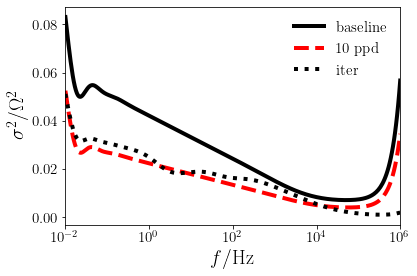

In [48]:
plt.semilogx(freq_virt_vec, sigma_im_virt_vec_0**2 + sigma_re_virt_vec_0**2, linewidth=4, color='black', linestyle = '-', label = 'baseline')
plt.semilogx(freq_virt_vec, sigma_im_virt_vec_10ppd**2 + sigma_re_virt_vec_10ppd**2, linewidth=4, color='red', linestyle = '--', label = '10 ppd')
plt.semilogx(freq_virt_vec, sigma_im_virt_vec_Np1**2 + sigma_re_virt_vec_Np1**2, linewidth=4, color='black', linestyle = ':', label = 'iter')

plt.xlim(1E-2, 1E6)
#plt.ylim(0, 1.0)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$\sigma^2/\Omega^2$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)

Text(0, 0.5, '$\\Delta\\sigma^2/\\Omega^2$')

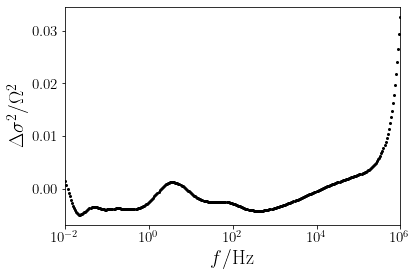

In [49]:
plt.semilogx(freq_virt_vec, sigma_im_virt_vec_10ppd**2 + sigma_re_virt_vec_10ppd**2 - (sigma_im_virt_vec_Np1**2 + sigma_re_virt_vec_Np1**2), 'o', markersize=2, color='black')

plt.xlim(1E-2, 1E6)
#plt.ylim(0, 1.0)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$\Delta\sigma^2/\Omega^2$', fontsize=20)

In [50]:
I_sigma_0 = np.trapz(sigma_im_virt_vec_0**2 + sigma_re_virt_vec_0**2, np.log10(freq_virt_vec))
I_sigma_10ppd =np.trapz(sigma_im_virt_vec_10ppd**2 + sigma_re_virt_vec_10ppd**2, np.log10(freq_virt_vec))
I_sigma_Np1 =np.trapz(sigma_im_virt_vec_Np1**2 + sigma_re_virt_vec_Np1**2, np.log10(freq_virt_vec))
print('σ2_0 = %.3F Ω2, σ2_10_ppd = %.3F Ω2, σ2_ALM_N = %.3F Ω2'%(I_sigma_0, I_sigma_10ppd, I_sigma_Np1))

σ2_0 = 0.225 Ω2, σ2_10_ppd = 0.124 Ω2, σ2_ALM_N = 0.129 Ω2


In [51]:
Z_exact_virt_vec = R_inf + 1j*(2*pi*freq_virt_vec)*L_0 + 1./(1./R_ct+T*(1j*2.*pi*freq_virt_vec)**phi)
mu_vec_10ppd = mu_re_virt_vec_10ppd + 1j*mu_im_virt_vec_10ppd
mu_vec_N = mu_re_virt_vec_Np1 + 1j*mu_im_virt_vec_Np1

epsilon_10ppd = 1.0/N_virt_freqs*np.linalg.norm(Z_exact_virt_vec-mu_vec_10ppd)
epsilon_N = 1.0/N_virt_freqs*np.linalg.norm(Z_exact_virt_vec-mu_vec_N)

In [52]:
print('rmse(Z_exact, Z_mu_10ppd) = %.5F Ω, rmse(Z_exact, Z_exact-Z_mu_N) = %.5F Ω'%(epsilon_10ppd, epsilon_N))

rmse(Z_exact, Z_mu_10ppd) = 0.00510 Ω, rmse(Z_exact, Z_exact-Z_mu_N) = 0.00532 Ω


In [53]:
T_0 = np.sum(1/freq_vec)/60
T_10ppd = np.sum(1/freq_vec_10ppd)/60
T_N = np.sum(1/freq_vec_N)/60

In [54]:
print('T_0 = %.2F min, T_10_ppd = %.2F min, T_N = %.2F min'%(T_0, T_10ppd, T_N))

T_0 = 4.52 min, T_10_ppd = 8.10 min, T_N = 7.29 min


In [55]:
np.save('./ALC_90bound/freq_vec', freq_vec)
np.save('./ALC_90bound/Z_exp', Z_exp)
np.save('./ALC_90bound/freq_virt_vec', freq_virt_vec)

np.save('./ALC_90bound/mu_re_virt_vec_0', mu_re_virt_vec_0)
np.save('./ALC_90bound/mu_im_virt_vec_0', mu_im_virt_vec_0)

np.save('./ALC_90bound/sigma_re_virt_vec_0', sigma_re_virt_vec_0)
np.save('./ALC_90bound/sigma_im_virt_vec_0', sigma_im_virt_vec_0)

np.save('./ALC_90bound/freq_new_vec', freq_new_vec)
np.save('./ALC_90bound/Z_exp_new_vec', Z_exp_new_vec)
np.save('./ALC_90bound/theta_new_vec', theta_new_vec)

np.save('./ALC_90bound/freq_vec_N', freq_vec_N)
np.save('./ALC_90bound/Z_exp_N', Z_exp_N)
np.save('./ALC_90bound/theta_N', theta_N)

np.save('./ALC_90bound/mu_re_virt_vec_new_vec', mu_re_virt_vec_new_vec)
np.save('./ALC_90bound/mu_im_virt_vec_new_vec', mu_im_virt_vec_new_vec)

np.save('./ALC_90bound/sigma_re_virt_vec_new_vec', sigma_re_virt_vec_new_vec)
np.save('./ALC_90bound/sigma_im_virt_vec_new_vec', sigma_im_virt_vec_new_vec)